# Chapter 5: Support Vector Machines

## Complete Theory, Implementation, and Exercises

**Based on "Hands-On Machine Learning" by Aurélien Géron**

---

### Table of Contents
1. [Introduction to Support Vector Machines](#introduction)
2. [Linear SVM Classification](#linear-svm)
3. [Soft Margin Classification](#soft-margin)
4. [Nonlinear SVM Classification](#nonlinear-svm)
5. [Polynomial Kernel](#polynomial-kernel)
6. [Similarity Features and Gaussian RBF Kernel](#rbf-kernel)
7. [SVM Regression](#svm-regression)
8. [Computational Complexity](#complexity)
9. [Under the Hood](#under-hood)
10. [Exercises](#exercises)

---

## 1. Introduction to Support Vector Machines

A **Support Vector Machine (SVM)** is a powerful and versatile Machine Learning model, capable of performing:
- Linear or nonlinear **classification**
- **Regression**
- **Outlier detection**

### Key Characteristics:
- One of the most popular models in Machine Learning
- Particularly well suited for classification of complex small- or medium-sized datasets
- Can handle both linear and nonlinear problems through the kernel trick

### Fundamental Concept:
The core idea behind SVMs is **large margin classification** - fitting the widest possible "street" between classes while minimizing classification errors.


In [59]:
# Google Colab Setup
import sys
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.svm import LinearSVC, SVC, SVR, LinearSVR
from sklearn.linear_model import SGDClassifier
from sklearn.datasets import make_moons, fetch_openml
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Configure matplotlib
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

print(f"Python version: {sys.version}")
print(f"NumPy version: {np.__version__}")
print(f"Scikit-learn version: {sklearn.__version__}")
print(f"Pandas version: {pd.__version__}")

Python version: 3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]
NumPy version: 2.0.2
Scikit-learn version: 1.6.1
Pandas version: 2.2.2


## 2. Linear SVM Classification

### Theory

The fundamental idea behind SVMs is best explained through **large margin classification**. Consider a linearly separable dataset with two classes.

#### Key Concepts:

1. **Decision Boundary**: A line (or hyperplane in higher dimensions) that separates the classes
2. **Margin**: The distance between the decision boundary and the nearest training instances
3. **Support Vectors**: The training instances that lie on the edge of the margin

#### Mathematical Formulation:

For a linear SVM classifier, the decision function is:

$$h_{\mathbf{w},b}(\mathbf{x}) = \mathbf{w}^T \mathbf{x} + b$$

The prediction is:
$$\hat{y} = \begin{cases}
0 & \text{if } \mathbf{w}^T \mathbf{x} + b < 0 \\
1 & \text{if } \mathbf{w}^T \mathbf{x} + b \geq 0
\end{cases}$$

where:
- $\mathbf{w}$ is the weight vector
- $b$ is the bias term
- $\mathbf{x}$ is the input feature vector


Dataset shape: (150, 2)
Features: petal length, petal width
Target: Iris virginica (1) vs others (0)
Class distribution: [100  50]


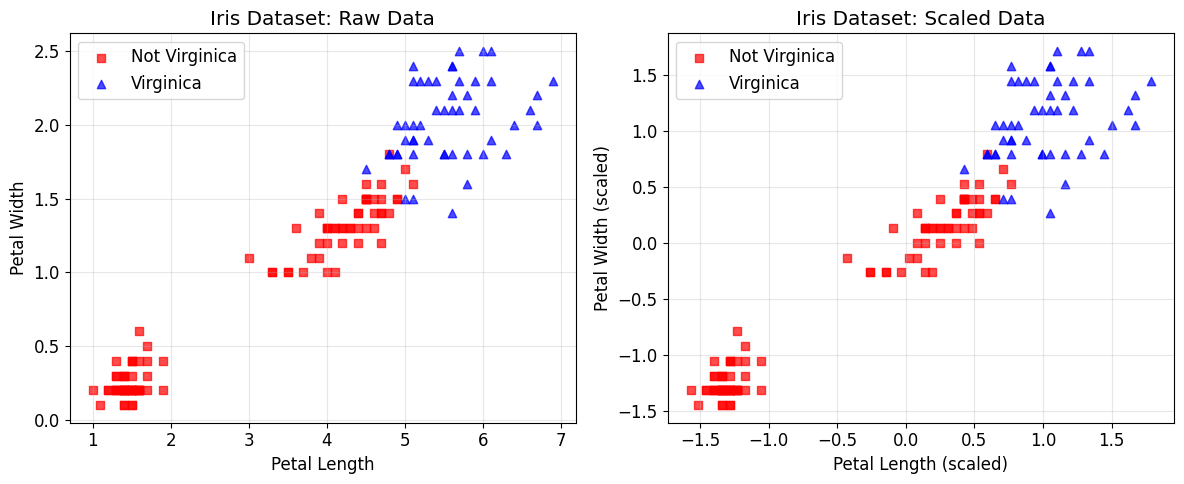

In [60]:
# Load and prepare the iris dataset for binary classification
iris = datasets.load_iris()
X = iris["data"][:, (2, 3)]  # petal length, petal width
y = (iris["target"] == 2).astype(np.float64)  # Iris virginica vs others

print(f"Dataset shape: {X.shape}")
print(f"Features: petal length, petal width")
print(f"Target: Iris virginica (1) vs others (0)")
print(f"Class distribution: {np.bincount(y.astype(int))}")

# Visualize the data
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(X[y==0, 0], X[y==0, 1], c='red', marker='s', label='Not Virginica', alpha=0.7)
plt.scatter(X[y==1, 0], X[y==1, 1], c='blue', marker='^', label='Virginica', alpha=0.7)
plt.xlabel('Petal Length')
plt.ylabel('Petal Width')
plt.title('Iris Dataset: Raw Data')
plt.legend()
plt.grid(True, alpha=0.3)

# Show feature scaling importance
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

plt.subplot(1, 2, 2)
plt.scatter(X_scaled[y==0, 0], X_scaled[y==0, 1], c='red', marker='s', label='Not Virginica', alpha=0.7)
plt.scatter(X_scaled[y==1, 0], X_scaled[y==1, 1], c='blue', marker='^', label='Virginica', alpha=0.7)
plt.xlabel('Petal Length (scaled)')
plt.ylabel('Petal Width (scaled)')
plt.title('Iris Dataset: Scaled Data')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Feature Scaling Importance

**SVMs are sensitive to feature scales** because they try to fit the largest possible margin between classes. If features have different scales:
- The algorithm may neglect smaller-scale features
- The decision boundary may be suboptimal

**Solution**: Always scale features using `StandardScaler` or similar techniques.


In [61]:
# Train a linear SVM classifier
svm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("linear_svc", LinearSVC(C=1, loss="hinge", random_state=42))
])

svm_clf.fit(X, y)

# Make predictions
y_pred = svm_clf.predict(X)
accuracy = accuracy_score(y, y_pred)
print(f"Training accuracy: {accuracy:.4f}")

# Test on a new instance
test_instance = [[5.5, 1.7]]
prediction = svm_clf.predict(test_instance)
print(f"Prediction for [5.5, 1.7]: {prediction[0]} ({'Virginica' if prediction[0] else 'Not Virginica'})")

# Note: SVMs don't output probabilities by default
print("\nNote: LinearSVC doesn't output probabilities by default")
print("Unlike Logistic Regression, SVM classifiers focus on decision boundaries, not probability estimation")

Training accuracy: 0.9600
Prediction for [5.5, 1.7]: 1.0 (Virginica)

Note: LinearSVC doesn't output probabilities by default
Unlike Logistic Regression, SVM classifiers focus on decision boundaries, not probability estimation


### Visualization Helper Function

Let's create a function to visualize SVM decision boundaries and margins.


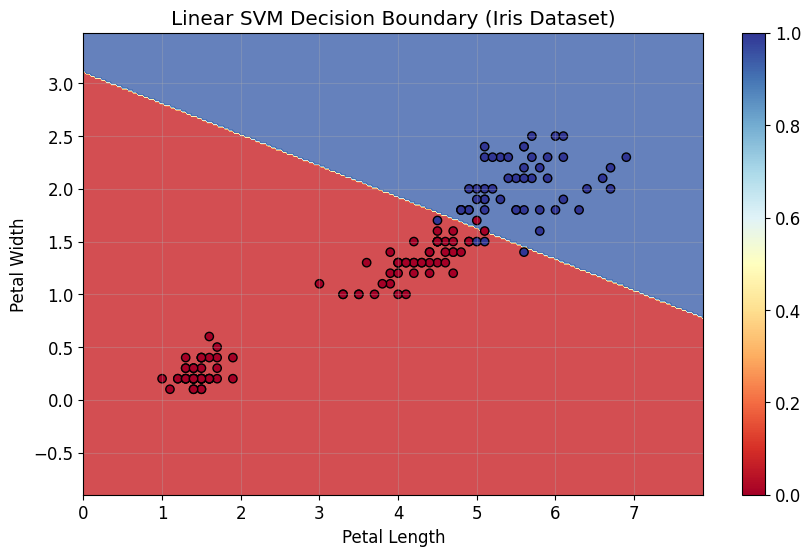

In [62]:
def plot_svm_decision_boundary(svm_clf, X, y, title="SVM Decision Boundary"):
    """
    Plot SVM decision boundary and margin

    Parameters:
    svm_clf: trained SVM classifier (pipeline or direct)
    X: feature matrix
    y: target vector
    title: plot title
    """
    plt.figure(figsize=(10, 6))

    # Create a mesh to plot the decision boundary
    h = 0.02  # step size in mesh
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # Make predictions on the mesh
    mesh_points = np.c_[xx.ravel(), yy.ravel()]
    Z = svm_clf.predict(mesh_points)
    Z = Z.reshape(xx.shape)

    # Plot the decision boundary
    plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.RdYlBu)

    # Plot the data points
    scatter = plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu, edgecolors='black')
    plt.colorbar(scatter)
    plt.xlabel('Petal Length')
    plt.ylabel('Petal Width')
    plt.title(title)
    plt.grid(True, alpha=0.3)

    return plt

# Visualize the linear SVM decision boundary
plot_svm_decision_boundary(svm_clf, X, y, "Linear SVM Decision Boundary (Iris Dataset)")
plt.show()

## 3. Soft Margin Classification

### Theory

**Hard margin classification** works only if:
1. Data is linearly separable
2. No outliers exist

**Soft margin classification** provides more flexibility by allowing some margin violations.

#### Mathematical Formulation:

**Hard Margin Objective:**
$$\min_{\mathbf{w},b} \frac{1}{2}\mathbf{w}^T\mathbf{w}$$
$$\text{subject to } t^{(i)}(\mathbf{w}^T\mathbf{x}^{(i)} + b) \geq 1 \text{ for } i = 1, 2, \ldots, m$$

where $t^{(i)} = -1$ for negative class and $t^{(i)} = 1$ for positive class.

**Soft Margin Objective:**
$$\min_{\mathbf{w},b,\zeta} \frac{1}{2}\mathbf{w}^T\mathbf{w} + C\sum_{i=1}^{m}\zeta^{(i)}$$
$$\text{subject to } t^{(i)}(\mathbf{w}^T\mathbf{x}^{(i)} + b) \geq 1 - \zeta^{(i)} \text{ and } \zeta^{(i)} \geq 0$$

#### Hyperparameter C:
- **Small C**: Wider margin, more margin violations (high bias, low variance)
- **Large C**: Narrower margin, fewer margin violations (low bias, high variance)

**If your SVM model is overfitting, you can try regularizing it by reducing C.**


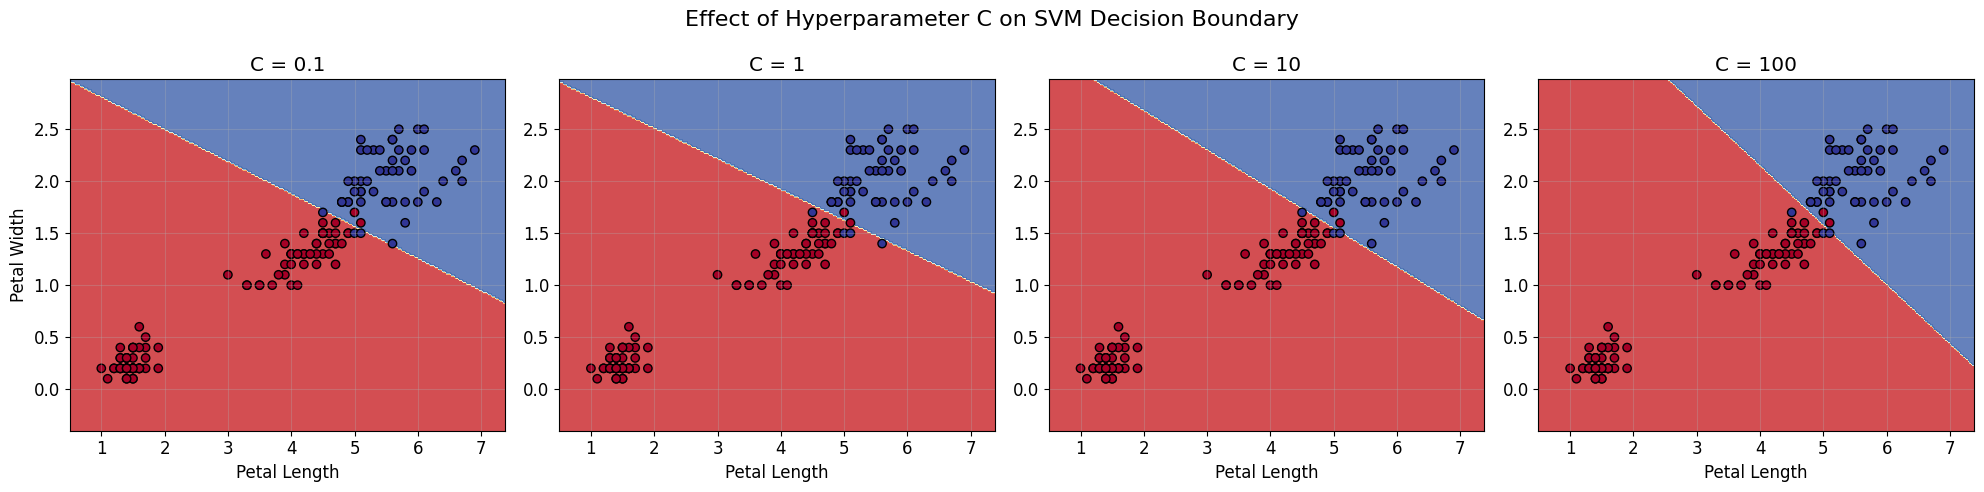

Observations:
- Low C (0.1): Wider margin, more regularization, simpler model
- High C (100): Narrower margin, less regularization, more complex model
- C controls the bias-variance tradeoff


In [63]:
# Demonstrate the effect of different C values
C_values = [0.1, 1, 10, 100]

plt.figure(figsize=(20, 5))

for i, C in enumerate(C_values):
    # Train SVM with different C values
    svm_clf_c = Pipeline([
        ("scaler", StandardScaler()),
        ("linear_svc", LinearSVC(C=C, loss="hinge", random_state=42))
    ])

    svm_clf_c.fit(X, y)

    plt.subplot(1, 4, i+1)

    # Create mesh for decision boundary
    h = 0.02
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    Z = svm_clf_c.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.RdYlBu)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu, edgecolors='black')
    plt.title(f'C = {C}')
    plt.xlabel('Petal Length')
    if i == 0:
        plt.ylabel('Petal Width')
    plt.grid(True, alpha=0.3)

plt.suptitle('Effect of Hyperparameter C on SVM Decision Boundary', fontsize=16)
plt.tight_layout()
plt.show()

print("Observations:")
print("- Low C (0.1): Wider margin, more regularization, simpler model")
print("- High C (100): Narrower margin, less regularization, more complex model")
print("- C controls the bias-variance tradeoff")

### SVM Implementation Alternatives

There are several ways to implement linear SVMs in Scikit-Learn:

1. **LinearSVC**: Fast, linear SVMs only
2. **SVC(kernel="linear")**: More flexible but slower
3. **SGDClassifier(loss="hinge")**: Stochastic Gradient Descent approach

#### Important LinearSVC Notes:
- Regularizes the bias term → center the training set first
- Use `loss="hinge"` (not default)
- Set `dual=False` for better performance when `n_features > n_samples`


In [64]:
# Compare different SVM implementations
from time import time

# Prepare classifiers
classifiers = {
    'LinearSVC': Pipeline([
        ('scaler', StandardScaler()),
        ('svm', LinearSVC(C=1, loss="hinge", random_state=42))
    ]),
    'SVC(linear)': Pipeline([
        ('scaler', StandardScaler()),
        ('svm', SVC(kernel="linear", C=1, random_state=42))
    ]),
    'SGDClassifier': Pipeline([
        ('scaler', StandardScaler()),
        ('svm', SGDClassifier(loss="hinge", alpha=1/(len(X)*1), random_state=42))
    ])
}

results = []

for name, clf in classifiers.items():
    start_time = time()
    clf.fit(X, y)
    train_time = time() - start_time

    y_pred = clf.predict(X)
    accuracy = accuracy_score(y, y_pred)

    results.append({
        'Classifier': name,
        'Training Time (s)': f"{train_time:.6f}",
        'Accuracy': f"{accuracy:.4f}"
    })

# Display results
results_df = pd.DataFrame(results)
print("SVM Implementation Comparison:")
print(results_df.to_string(index=False))

print("\nKey Differences:")
print("- LinearSVC: Fastest for linear problems, optimized for linear SVMs")
print("- SVC(linear): More flexible, supports kernel trick, slower")
print("- SGDClassifier: Good for large datasets, online learning capable")

SVM Implementation Comparison:
   Classifier Training Time (s) Accuracy
    LinearSVC          0.008311   0.9600
  SVC(linear)          0.003319   0.9533
SGDClassifier          0.003093   0.9600

Key Differences:
- LinearSVC: Fastest for linear problems, optimized for linear SVMs
- SVC(linear): More flexible, supports kernel trick, slower
- SGDClassifier: Good for large datasets, online learning capable


## 4. Nonlinear SVM Classification

### Theory

Many datasets are not linearly separable. There are two main approaches to handle nonlinear datasets:

1. **Add polynomial features**: Transform the data to higher dimensions where it becomes linearly separable
2. **Kernel trick**: Achieve the same result without actually computing the transformation

#### Polynomial Features Approach:

Consider a 1D dataset that's not linearly separable. If we add a feature $x_2 = (x_1)^2$, the resulting 2D dataset might become linearly separable.

**Example transformation:**
- Original: $x_1$
- Transformed: $(x_1, x_1^2)$


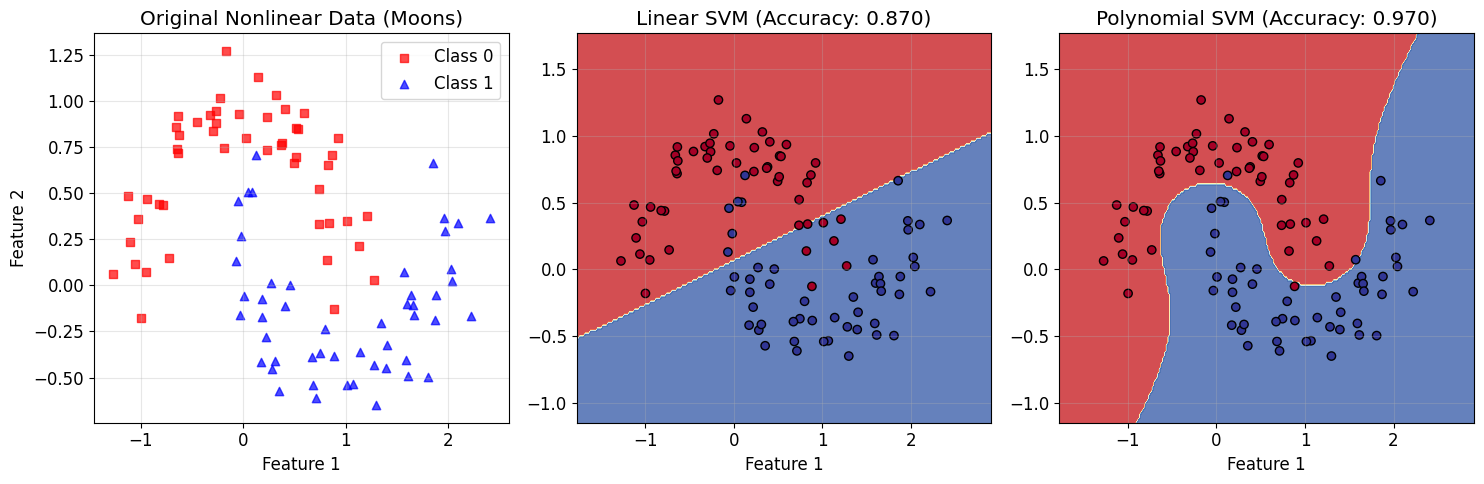

Polynomial features approach:
- Original features: 2
- After polynomial transformation (degree 3): 10
- Linear SVM accuracy: 0.870
- Polynomial SVM accuracy: 0.970


In [65]:
# Create nonlinear dataset (moons)
X_moons, y_moons = make_moons(n_samples=100, noise=0.15, random_state=42)

plt.figure(figsize=(15, 5))

# Plot original nonlinear data
plt.subplot(1, 3, 1)
plt.scatter(X_moons[y_moons==0, 0], X_moons[y_moons==0, 1], c='red', marker='s', label='Class 0', alpha=0.7)
plt.scatter(X_moons[y_moons==1, 0], X_moons[y_moons==1, 1], c='blue', marker='^', label='Class 1', alpha=0.7)
plt.title('Original Nonlinear Data (Moons)')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True, alpha=0.3)

# Try linear SVM on nonlinear data
linear_svm = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", LinearSVC(C=1, loss="hinge", random_state=42))
])
linear_svm.fit(X_moons, y_moons)

plt.subplot(1, 3, 2)
h = 0.02
x_min, x_max = X_moons[:, 0].min() - 0.5, X_moons[:, 0].max() + 0.5
y_min, y_max = X_moons[:, 1].min() - 0.5, X_moons[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = linear_svm.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.RdYlBu)
plt.scatter(X_moons[:, 0], X_moons[:, 1], c=y_moons, cmap=plt.cm.RdYlBu, edgecolors='black')
plt.title(f'Linear SVM (Accuracy: {linear_svm.score(X_moons, y_moons):.3f})')
plt.xlabel('Feature 1')
plt.grid(True, alpha=0.3)

# Add polynomial features
polynomial_svm = Pipeline([
    ("poly_features", PolynomialFeatures(degree=3)),
    ("scaler", StandardScaler()),
    ("svm", LinearSVC(C=10, loss="hinge", random_state=42))
])
polynomial_svm.fit(X_moons, y_moons)

plt.subplot(1, 3, 3)
Z_poly = polynomial_svm.predict(np.c_[xx.ravel(), yy.ravel()])
Z_poly = Z_poly.reshape(xx.shape)
plt.contourf(xx, yy, Z_poly, alpha=0.8, cmap=plt.cm.RdYlBu)
plt.scatter(X_moons[:, 0], X_moons[:, 1], c=y_moons, cmap=plt.cm.RdYlBu, edgecolors='black')
plt.title(f'Polynomial SVM (Accuracy: {polynomial_svm.score(X_moons, y_moons):.3f})')
plt.xlabel('Feature 1')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Polynomial features approach:")
print(f"- Original features: {X_moons.shape[1]}")
X_poly = PolynomialFeatures(degree=3).fit_transform(X_moons)
print(f"- After polynomial transformation (degree 3): {X_poly.shape[1]}")
print(f"- Linear SVM accuracy: {linear_svm.score(X_moons, y_moons):.3f}")
print(f"- Polynomial SVM accuracy: {polynomial_svm.score(X_moons, y_moons):.3f}")

## 5. Polynomial Kernel

### Theory

Adding polynomial features works but has limitations:
- **Low degree**: Cannot deal with very complex datasets
- **High degree**: Creates huge number of features (combinatorial explosion)

The **kernel trick** solves this problem:
- Get the same result as adding polynomial features
- Without actually computing the transformation
- No combinatorial explosion of features

#### Mathematical Foundation:

**Polynomial Kernel:**
$$K(\mathbf{a}, \mathbf{b}) = (\gamma \mathbf{a}^T \mathbf{b} + r)^d$$

where:
- $d$: degree of the polynomial
- $\gamma$: kernel coefficient
- $r$: coef0 parameter (controls influence of high vs low degree polynomials)

#### Hyperparameters:
- **degree**: Polynomial degree
- **coef0**: Controls high-degree vs low-degree polynomial influence
- **C**: Regularization parameter


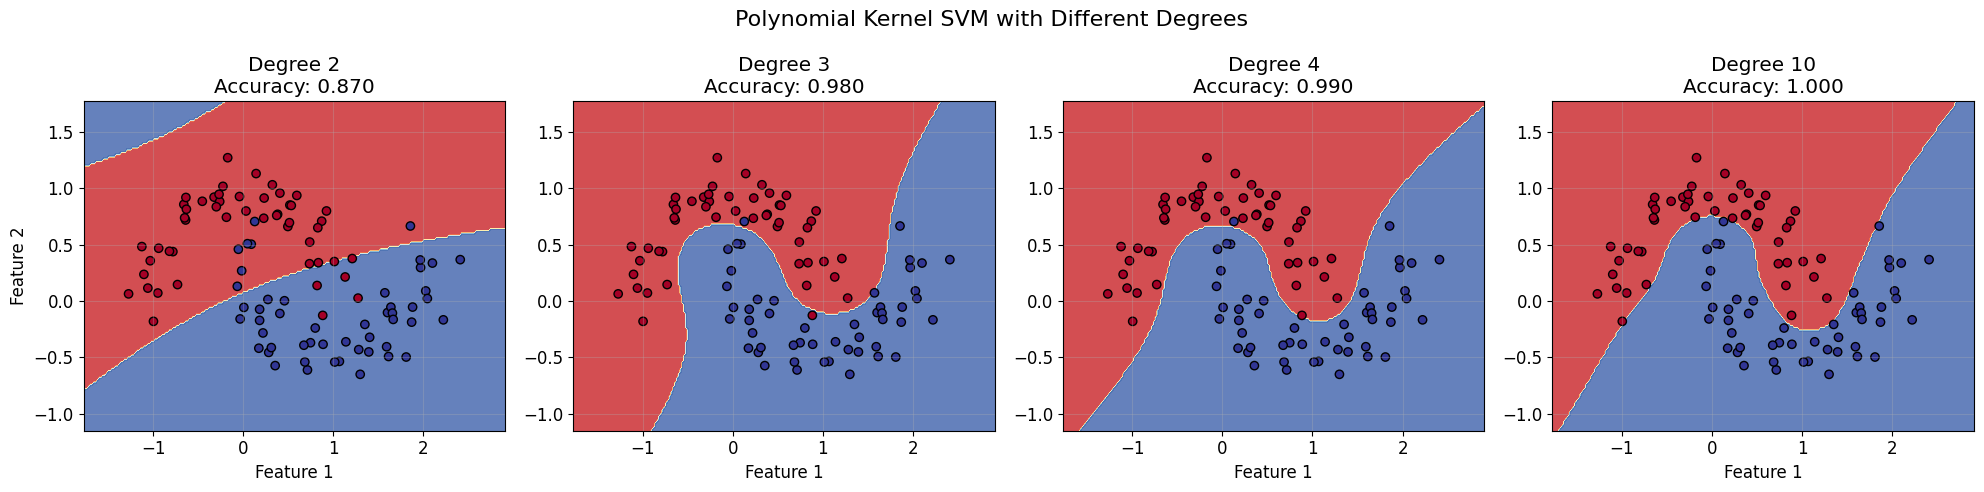

Observations:
- Higher degree: More flexible decision boundary
- Too high degree: Risk of overfitting
- Optimal degree depends on the dataset complexity

Kernel Trick Efficiency:
- Original features: 2
- Polynomial features (degree 3) would create: 10 features
- Kernel trick: Uses only original 2 features internally


In [66]:
# Polynomial Kernel SVM
poly_kernel_svm = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC(kernel="poly", degree=3, coef0=1, C=5, random_state=42))
])

poly_kernel_svm.fit(X_moons, y_moons)

# Compare different polynomial degrees
degrees = [2, 3, 4, 10]

plt.figure(figsize=(20, 5))

for i, degree in enumerate(degrees):
    svm_poly = Pipeline([
        ("scaler", StandardScaler()),
        ("svm", SVC(kernel="poly", degree=degree, coef0=1, C=5, random_state=42))
    ])

    svm_poly.fit(X_moons, y_moons)

    plt.subplot(1, 4, i+1)

    # Plot decision boundary
    h = 0.02
    x_min, x_max = X_moons[:, 0].min() - 0.5, X_moons[:, 0].max() + 0.5
    y_min, y_max = X_moons[:, 1].min() - 0.5, X_moons[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    Z = svm_poly.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.RdYlBu)
    plt.scatter(X_moons[:, 0], X_moons[:, 1], c=y_moons, cmap=plt.cm.RdYlBu, edgecolors='black')

    accuracy = svm_poly.score(X_moons, y_moons)
    plt.title(f'Degree {degree}\nAccuracy: {accuracy:.3f}')
    plt.xlabel('Feature 1')
    if i == 0:
        plt.ylabel('Feature 2')
    plt.grid(True, alpha=0.3)

plt.suptitle('Polynomial Kernel SVM with Different Degrees', fontsize=16)
plt.tight_layout()
plt.show()

print("Observations:")
print("- Higher degree: More flexible decision boundary")
print("- Too high degree: Risk of overfitting")
print("- Optimal degree depends on the dataset complexity")

# Show the efficiency of kernel trick
print(f"\nKernel Trick Efficiency:")
print(f"- Original features: {X_moons.shape[1]}")
print(f"- Polynomial features (degree 3) would create: {PolynomialFeatures(degree=3).fit_transform(X_moons).shape[1]} features")
print(f"- Kernel trick: Uses only original {X_moons.shape[1]} features internally")

## 6. Similarity Features and Gaussian RBF Kernel

### Theory

Another technique for nonlinear problems is to add **similarity features** using similarity functions.

#### Gaussian Radial Basis Function (RBF):

$$\phi_\gamma(\mathbf{x}, \ell) = \exp(-\gamma \|\mathbf{x} - \ell\|^2)$$

This is a bell-shaped function:
- **Value at landmark**: $\phi_\gamma(\ell, \ell) = 1$
- **Value far from landmark**: $\phi_\gamma(\mathbf{x}, \ell) \to 0$

#### Gaussian RBF Kernel:

$$K(\mathbf{a}, \mathbf{b}) = \exp(-\gamma \|\mathbf{a} - \mathbf{b}\|^2)$$

#### Hyperparameters:

**γ (gamma)** acts as a regularization parameter:
- **High γ**: Narrow bell curve, small influence range, more irregular boundary (overfitting risk)
- **Low γ**: Wide bell curve, large influence range, smoother boundary (underfitting risk)

**C** controls the margin violations:
- **High C**: Fewer margin violations, more complex model
- **Low C**: More margin violations, simpler model


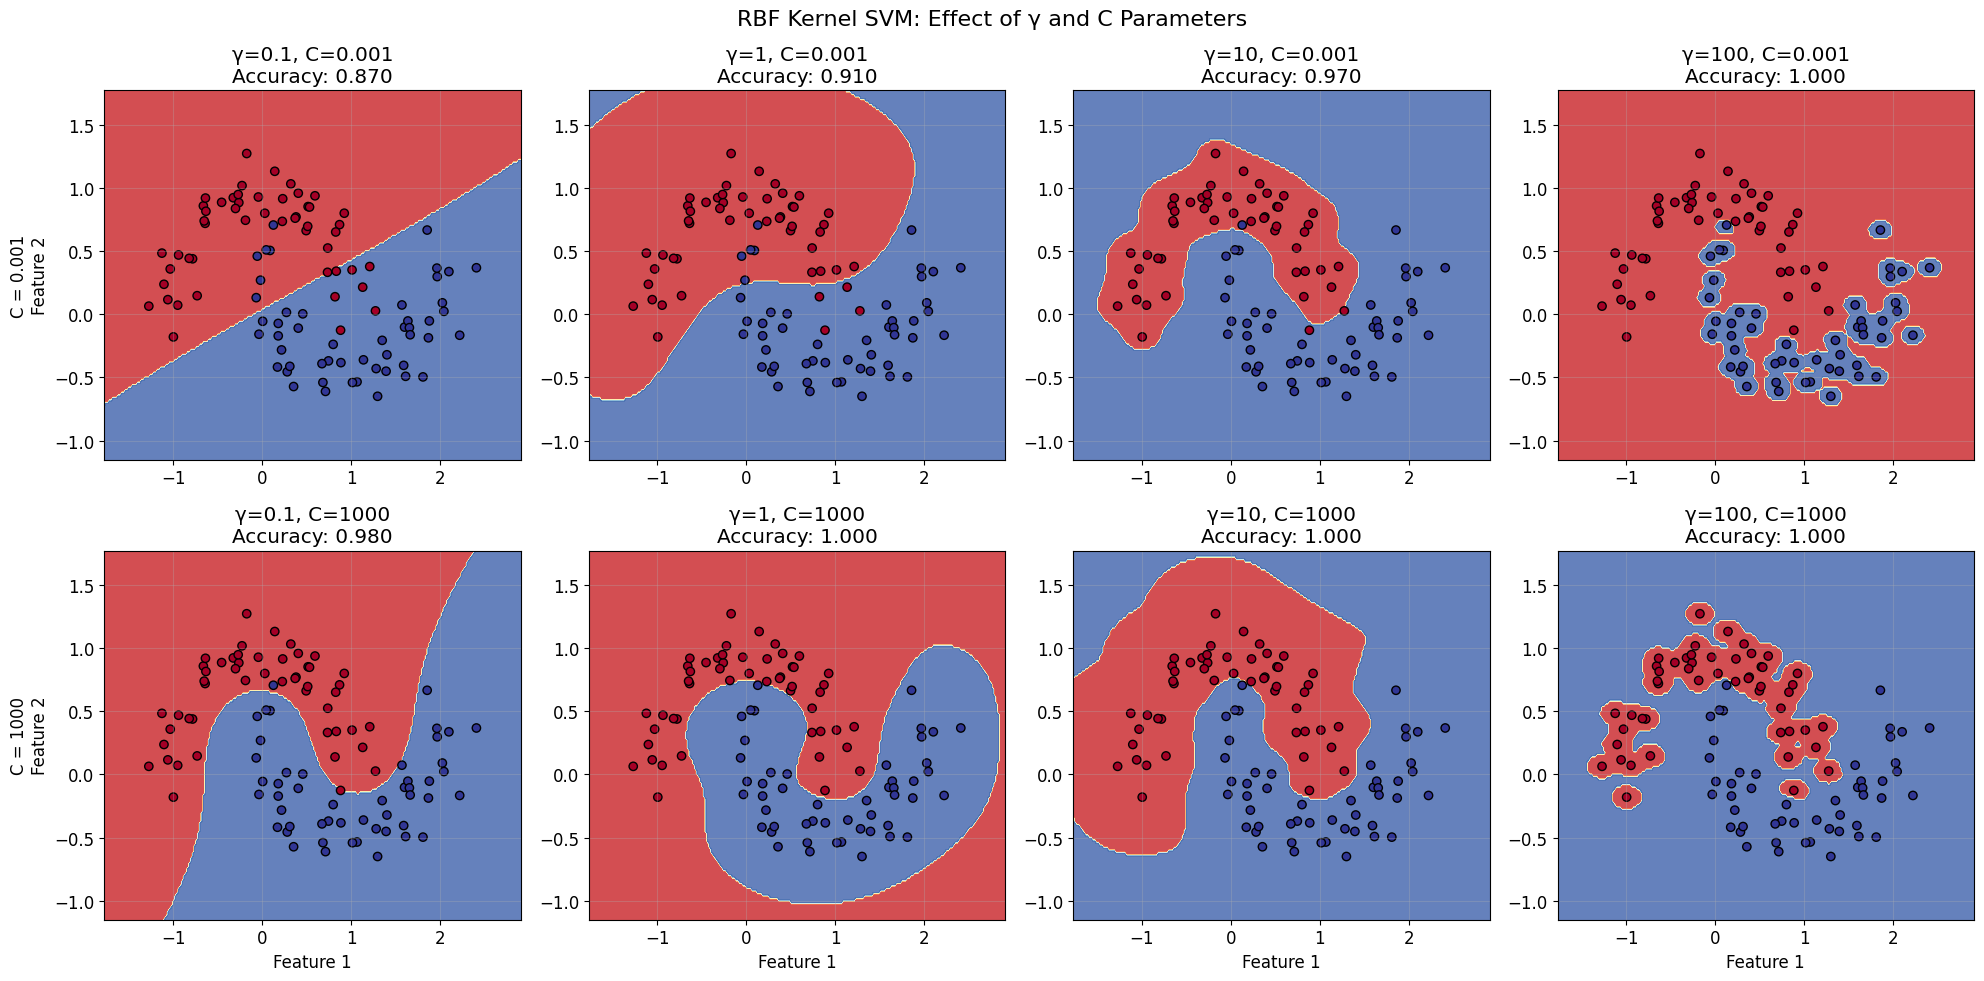

Parameter Effects:
γ (gamma):
- Low γ (0.1): Wide influence, smooth boundary, may underfit
- High γ (100): Narrow influence, irregular boundary, may overfit

C:
- Low C (0.001): More regularization, simpler model
- High C (1000): Less regularization, more complex model


In [67]:
# Demonstrate RBF kernel with different gamma values
gamma_values = [0.1, 1, 10, 100]

plt.figure(figsize=(20, 10))

for i, gamma in enumerate(gamma_values):
    for j, C in enumerate([0.001, 1000]):
        svm_rbf = Pipeline([
            ("scaler", StandardScaler()),
            ("svm", SVC(kernel="rbf", gamma=gamma, C=C, random_state=42))
        ])

        svm_rbf.fit(X_moons, y_moons)

        plt.subplot(2, 4, j*4 + i + 1)

        # Plot decision boundary
        h = 0.02
        x_min, x_max = X_moons[:, 0].min() - 0.5, X_moons[:, 0].max() + 0.5
        y_min, y_max = X_moons[:, 1].min() - 0.5, X_moons[:, 1].max() + 0.5
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

        Z = svm_rbf.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)

        plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.RdYlBu)
        plt.scatter(X_moons[:, 0], X_moons[:, 1], c=y_moons, cmap=plt.cm.RdYlBu, edgecolors='black')

        accuracy = svm_rbf.score(X_moons, y_moons)
        plt.title(f'γ={gamma}, C={C}\nAccuracy: {accuracy:.3f}')

        if j == 1:
            plt.xlabel('Feature 1')
        if i == 0:
            if j == 0:
                plt.ylabel('C = 0.001\nFeature 2')
            else:
                plt.ylabel('C = 1000\nFeature 2')
        plt.grid(True, alpha=0.3)

plt.suptitle('RBF Kernel SVM: Effect of γ and C Parameters', fontsize=16)
plt.tight_layout()
plt.show()

print("Parameter Effects:")
print("γ (gamma):")
print("- Low γ (0.1): Wide influence, smooth boundary, may underfit")
print("- High γ (100): Narrow influence, irregular boundary, may overfit")
print("\nC:")
print("- Low C (0.001): More regularization, simpler model")
print("- High C (1000): Less regularization, more complex model")

### Kernel Selection Guidelines

**Rule of thumb for kernel selection:**

1. **Linear kernel first**: Always try linear kernel first
   - Use `LinearSVC` (much faster than `SVC(kernel="linear")`)
   - Especially if training set is very large or has many features

2. **Gaussian RBF kernel**: If training set is not too large
   - Works well in most cases
   - Good default choice for nonlinear problems

3. **Other kernels**: If you have spare time and computing power
   - Polynomial kernel for specific polynomial relationships
   - Specialized kernels for specific data structures (e.g., string kernels for text)

4. **Cross-validation and grid search**: For optimal hyperparameter tuning


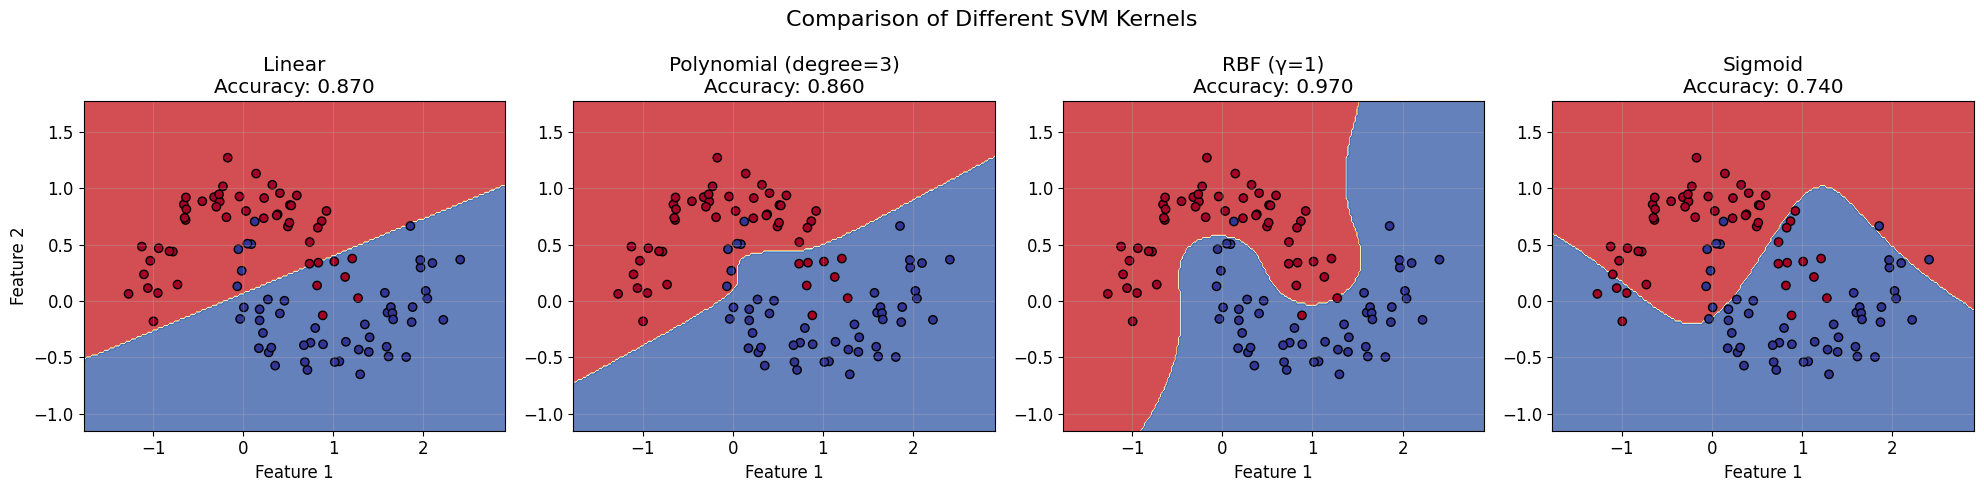

Kernel Comparison Results:
- Linear: 0.870
- Polynomial (degree=3): 0.860
- RBF (γ=1): 0.970
- Sigmoid: 0.740


In [68]:
# Compare different kernels
kernels = {
    'Linear': SVC(kernel='linear', C=1, random_state=42),
    'Polynomial (degree=3)': SVC(kernel='poly', degree=3, C=1, random_state=42),
    'RBF (γ=1)': SVC(kernel='rbf', gamma=1, C=1, random_state=42),
    'Sigmoid': SVC(kernel='sigmoid', C=1, random_state=42)
}

plt.figure(figsize=(20, 5))

for i, (name, svm) in enumerate(kernels.items()):
    # Create pipeline
    svm_pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("svm", svm)
    ])

    svm_pipeline.fit(X_moons, y_moons)

    plt.subplot(1, 4, i+1)

    # Plot decision boundary
    h = 0.02
    x_min, x_max = X_moons[:, 0].min() - 0.5, X_moons[:, 0].max() + 0.5
    y_min, y_max = X_moons[:, 1].min() - 0.5, X_moons[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    Z = svm_pipeline.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.RdYlBu)
    plt.scatter(X_moons[:, 0], X_moons[:, 1], c=y_moons, cmap=plt.cm.RdYlBu, edgecolors='black')

    accuracy = svm_pipeline.score(X_moons, y_moons)
    plt.title(f'{name}\nAccuracy: {accuracy:.3f}')
    plt.xlabel('Feature 1')
    if i == 0:
        plt.ylabel('Feature 2')
    plt.grid(True, alpha=0.3)

plt.suptitle('Comparison of Different SVM Kernels', fontsize=16)
plt.tight_layout()
plt.show()

print("Kernel Comparison Results:")
for name, svm in kernels.items():
    svm_pipeline = Pipeline([("scaler", StandardScaler()), ("svm", svm)])
    svm_pipeline.fit(X_moons, y_moons)
    accuracy = svm_pipeline.score(X_moons, y_moons)
    print(f"- {name}: {accuracy:.3f}")

## 7. SVM Regression

### Theory

SVMs can also be used for **regression** tasks. The objective is reversed:
- **Classification**: Fit largest possible margin between classes
- **Regression**: Fit as many instances as possible within the margin

#### Key Concepts:

1. **ε-insensitive**: Adding instances within the margin doesn't affect predictions
2. **Margin width**: Controlled by hyperparameter ε (epsilon)
3. **Support vectors**: Instances on the margin boundaries or outside the margin

#### Mathematical Formulation:

**Linear SVM Regression cost function:**
$$J(\mathbf{w}, b) = \frac{1}{2}\mathbf{w}^T\mathbf{w} + C\sum_{i=1}^{m}\max(0, |y^{(i)} - (\mathbf{w}^T\mathbf{x}^{(i)} + b)| - \varepsilon)$$

#### Hyperparameters:
- **ε (epsilon)**: Margin width (larger ε = wider margin)
- **C**: Regularization (larger C = less regularization)


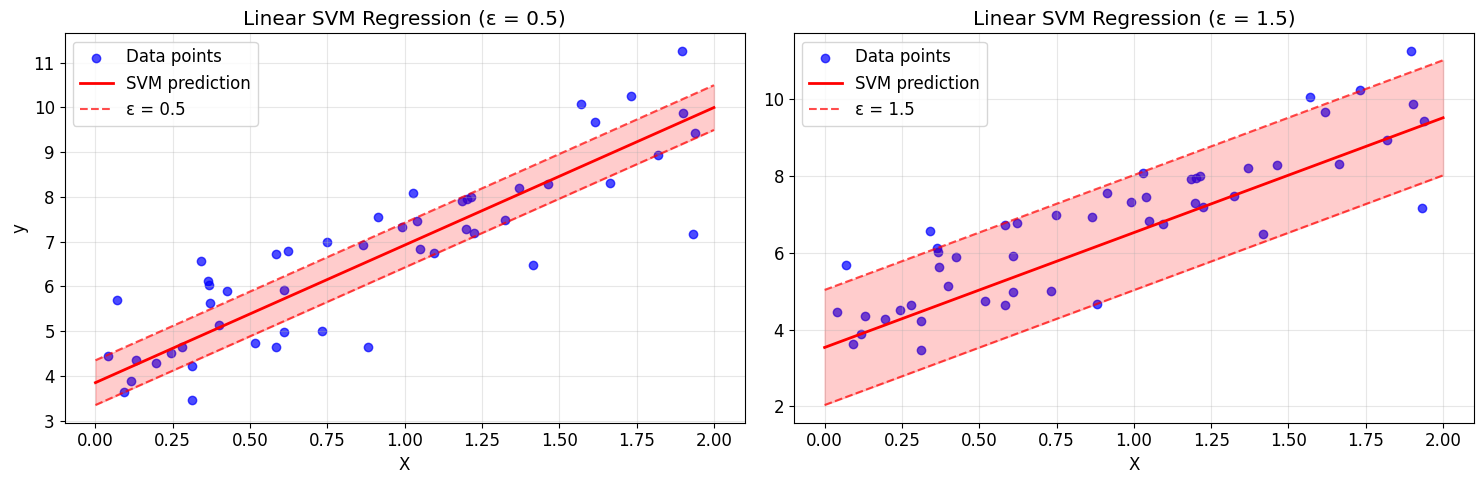

SVM Regression Characteristics:
- ε controls the margin width
- Points within the margin don't affect the model (ε-insensitive)
- Larger ε: wider margin, more tolerance for errors
- Smaller ε: narrower margin, less tolerance for errors


In [69]:
# Generate regression dataset
np.random.seed(42)
m = 50
X_reg = 2 * np.random.rand(m, 1)
y_reg = (4 + 3 * X_reg + np.random.randn(m, 1)).ravel()

# Linear SVM Regression with different epsilon values
epsilons = [0.5, 1.5]

plt.figure(figsize=(15, 5))

for i, epsilon in enumerate(epsilons):
    svm_reg = LinearSVR(epsilon=epsilon, random_state=42)
    svm_reg.fit(X_reg, y_reg)

    # Generate predictions for plotting
    X_plot = np.linspace(0, 2, 100).reshape(-1, 1)
    y_pred = svm_reg.predict(X_plot)

    plt.subplot(1, 2, i+1)

    # Plot data points
    plt.scatter(X_reg, y_reg, alpha=0.7, color='blue', label='Data points')

    # Plot regression line
    plt.plot(X_plot, y_pred, color='red', linewidth=2, label='SVM prediction')

    # Plot margin
    plt.plot(X_plot, y_pred + epsilon, color='red', linestyle='--', alpha=0.7, label=f'ε = {epsilon}')
    plt.plot(X_plot, y_pred - epsilon, color='red', linestyle='--', alpha=0.7)

    # Fill margin area
    plt.fill_between(X_plot.ravel(), y_pred - epsilon, y_pred + epsilon, alpha=0.2, color='red')

    plt.title(f'Linear SVM Regression (ε = {epsilon})')
    plt.xlabel('X')
    if i == 0:
        plt.ylabel('y')
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("SVM Regression Characteristics:")
print("- ε controls the margin width")
print("- Points within the margin don't affect the model (ε-insensitive)")
print("- Larger ε: wider margin, more tolerance for errors")
print("- Smaller ε: narrower margin, less tolerance for errors")

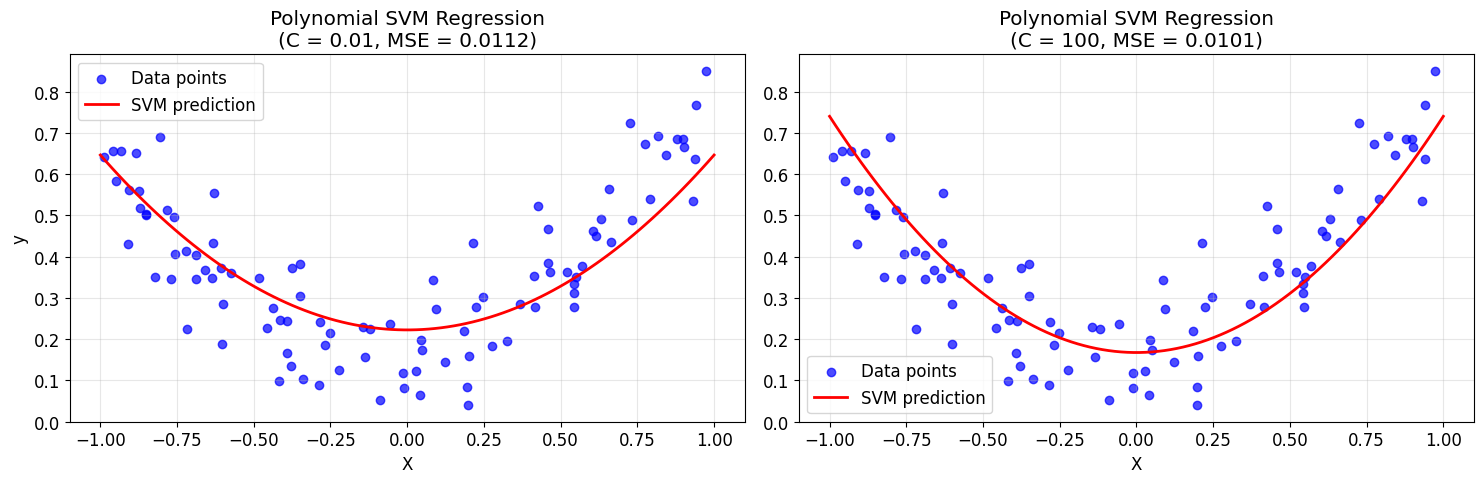

Nonlinear SVM Regression:
- Low C: More regularization, smoother curve
- High C: Less regularization, more flexible curve
- Polynomial kernel captures nonlinear relationships


In [70]:
# Nonlinear SVM Regression using polynomial kernel
# Generate quadratic dataset
np.random.seed(42)
m = 100
X_quad = 2 * np.random.rand(m, 1) - 1
y_quad = (0.2 + 0.1 * X_quad + 0.5 * X_quad**2 + np.random.randn(m, 1) * 0.1).ravel()

# Compare different C values for polynomial SVM regression
C_values = [0.01, 100]

plt.figure(figsize=(15, 5))

for i, C in enumerate(C_values):
    svm_poly_reg = SVR(kernel="poly", degree=2, C=C, epsilon=0.1)
    svm_poly_reg.fit(X_quad, y_quad)

    # Generate predictions for plotting
    X_plot = np.linspace(-1, 1, 100).reshape(-1, 1)
    y_pred = svm_poly_reg.predict(X_plot)

    plt.subplot(1, 2, i+1)

    # Plot data points
    plt.scatter(X_quad, y_quad, alpha=0.7, color='blue', label='Data points')

    # Plot regression curve
    plt.plot(X_plot, y_pred, color='red', linewidth=2, label='SVM prediction')

    mse = mean_squared_error(y_quad, svm_poly_reg.predict(X_quad))
    plt.title(f'Polynomial SVM Regression\n(C = {C}, MSE = {mse:.4f})')
    plt.xlabel('X')
    if i == 0:
        plt.ylabel('y')
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Nonlinear SVM Regression:")
print("- Low C: More regularization, smoother curve")
print("- High C: Less regularization, more flexible curve")
print("- Polynomial kernel captures nonlinear relationships")

## 8. Computational Complexity

### Training Time Complexity

| Algorithm | Time Complexity | Out-of-core | Scaling Required | Kernel Trick |
|-----------|----------------|-------------|------------------|---------------|
| **LinearSVC** | O(m × n) | No | Yes | No |
| **SGDClassifier** | O(m × n) | Yes | Yes | No |
| **SVC** | O(m² × n) to O(m³ × n) | No | Yes | Yes |

### Key Points:

1. **LinearSVC**:
   - Based on liblinear library
   - Scales almost linearly with instances and features
   - No kernel trick support
   - Best for large datasets with linear relationships

2. **SVC**:
   - Based on libsvm library
   - Supports kernel trick
   - Gets slow with large datasets (hundreds of thousands of instances)
   - Perfect for complex small/medium datasets

3. **SGDClassifier**:
   - Uses Stochastic Gradient Descent
   - Supports online learning
   - Good for huge datasets that don't fit in memory


Testing with 100 samples...
Testing with 500 samples...
Testing with 1000 samples...
Testing with 2000 samples...

Training Time Comparison (seconds):
   Size  LinearSVC     SVC  SGDClassifier
0   100     0.0053  0.0029         0.0021
1   500     0.0058  0.0119         0.0037
2  1000     0.0086  0.0298         0.0047
3  2000     0.0147     NaN         0.0061


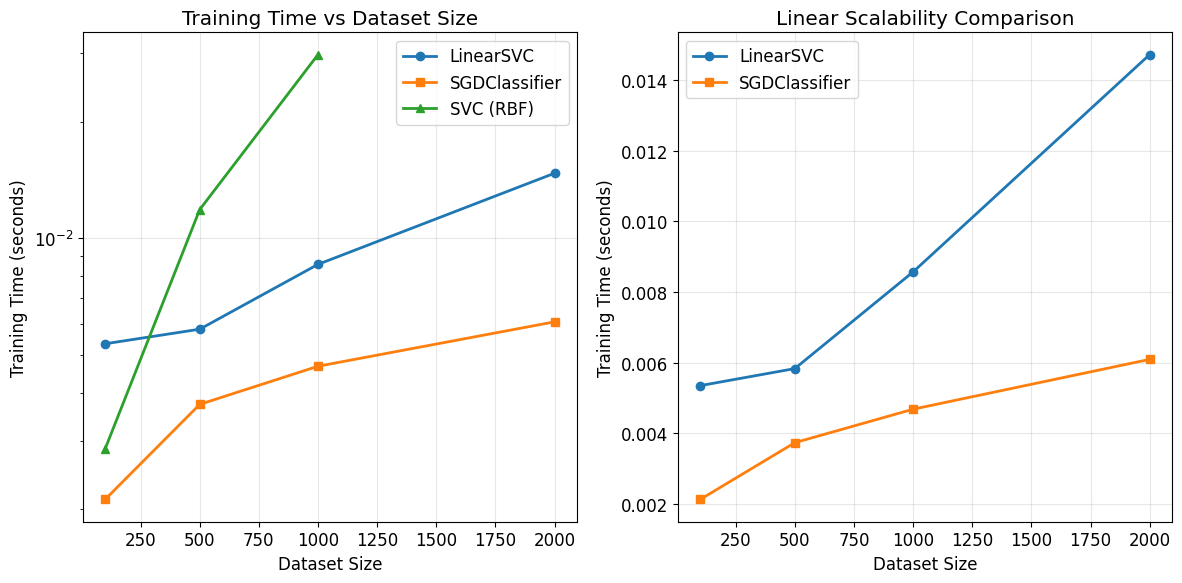


Complexity Analysis:
- LinearSVC: Scales linearly, fastest for linear problems
- SGDClassifier: Also linear scaling, good for online learning
- SVC: Quadratic to cubic scaling, slow for large datasets


In [71]:
# Demonstrate complexity differences with varying dataset sizes
from time import time
from sklearn.datasets import make_classification

# Generate datasets of different sizes
sizes = [100, 500, 1000, 2000]
results = {'Size': [], 'LinearSVC': [], 'SVC': [], 'SGDClassifier': []}

for size in sizes:
    print(f"Testing with {size} samples...")

    # Generate dataset
    X_test, y_test = make_classification(n_samples=size, n_features=20, n_redundant=0,
                                        n_informative=2, random_state=42, n_clusters_per_class=1)

    results['Size'].append(size)

    # Test LinearSVC
    start = time()
    linear_svc = Pipeline([("scaler", StandardScaler()),
                          ("svm", LinearSVC(C=1, loss="hinge", random_state=42))])
    linear_svc.fit(X_test, y_test)
    results['LinearSVC'].append(time() - start)

    # Test SVC (only for smaller datasets to avoid long wait times)
    if size <= 1000:
        start = time()
        svc = Pipeline([("scaler", StandardScaler()),
                       ("svm", SVC(kernel="rbf", C=1, random_state=42))])
        svc.fit(X_test, y_test)
        results['SVC'].append(time() - start)
    else:
        results['SVC'].append(np.nan)  # Too slow for large datasets

    # Test SGDClassifier
    start = time()
    sgd = Pipeline([("scaler", StandardScaler()),
                   ("svm", SGDClassifier(loss="hinge", alpha=0.01, random_state=42))])
    sgd.fit(X_test, y_test)
    results['SGDClassifier'].append(time() - start)

# Create results DataFrame
complexity_df = pd.DataFrame(results)
print("\nTraining Time Comparison (seconds):")
print(complexity_df.round(4))

# Plot results
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(complexity_df['Size'], complexity_df['LinearSVC'], 'o-', label='LinearSVC', linewidth=2)
plt.plot(complexity_df['Size'], complexity_df['SGDClassifier'], 's-', label='SGDClassifier', linewidth=2)
# Only plot SVC for non-NaN values
svc_data = complexity_df.dropna(subset=['SVC'])
plt.plot(svc_data['Size'], svc_data['SVC'], '^-', label='SVC (RBF)', linewidth=2)
plt.xlabel('Dataset Size')
plt.ylabel('Training Time (seconds)')
plt.title('Training Time vs Dataset Size')
plt.legend()
plt.grid(True, alpha=0.3)
plt.yscale('log')

plt.subplot(1, 2, 2)
# Show only LinearSVC and SGD for clarity
plt.plot(complexity_df['Size'], complexity_df['LinearSVC'], 'o-', label='LinearSVC', linewidth=2)
plt.plot(complexity_df['Size'], complexity_df['SGDClassifier'], 's-', label='SGDClassifier', linewidth=2)
plt.xlabel('Dataset Size')
plt.ylabel('Training Time (seconds)')
plt.title('Linear Scalability Comparison')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nComplexity Analysis:")
print("- LinearSVC: Scales linearly, fastest for linear problems")
print("- SGDClassifier: Also linear scaling, good for online learning")
print("- SVC: Quadratic to cubic scaling, slow for large datasets")

## 9. Under the Hood

### Decision Function and Predictions

The linear SVM classifier predicts the class by computing:

$$\mathbf{w}^T \mathbf{x} + b = w_1 x_1 + w_2 x_2 + \cdots + w_n x_n + b$$

**Prediction rule:**
$$\hat{y} = \begin{cases}
0 & \text{if } \mathbf{w}^T \mathbf{x} + b < 0 \\
1 & \text{if } \mathbf{w}^T \mathbf{x} + b \geq 0
\end{cases}$$

### Training Objective

The goal is to maximize the margin, which means minimizing $\|\mathbf{w}\|$.

**Hard Margin Linear SVM:**
$$\min_{\mathbf{w},b} \frac{1}{2}\mathbf{w}^T\mathbf{w}$$
$$\text{subject to } t^{(i)}(\mathbf{w}^T\mathbf{x}^{(i)} + b) \geq 1 \text{ for } i = 1, 2, \ldots, m$$

**Soft Margin Linear SVM:**
$$\min_{\mathbf{w},b,\zeta} \frac{1}{2}\mathbf{w}^T\mathbf{w} + C\sum_{i=1}^{m}\zeta^{(i)}$$
$$\text{subject to } t^{(i)}(\mathbf{w}^T\mathbf{x}^{(i)} + b) \geq 1 - \zeta^{(i)} \text{ and } \zeta^{(i)} \geq 0$$

### The Dual Problem

The dual formulation of the SVM problem:

$$\min_{\alpha} \frac{1}{2}\sum_{i=1}^{m}\sum_{j=1}^{m}\alpha_i\alpha_j t^{(i)}t^{(j)}\mathbf{x}^{(i)T}\mathbf{x}^{(j)} - \sum_{i=1}^{m}\alpha_i$$
$$\text{subject to } \alpha_i \geq 0 \text{ for } i = 1, 2, \ldots, m$$

**Converting back to primal:**
$$\mathbf{w} = \sum_{i=1}^{m}\alpha_i t^{(i)}\mathbf{x}^{(i)}$$

### Kernelized SVMs

For kernelized SVMs, predictions involve only support vectors:

$$h_{\mathbf{w},b}(\phi(\mathbf{x}^{(n)})) = \sum_{i=1, \alpha_i > 0}^{m}\alpha_i t^{(i)} K(\mathbf{x}^{(i)}, \mathbf{x}^{(n)}) + b$$

**Common kernels:**
- **Linear**: $K(\mathbf{a}, \mathbf{b}) = \mathbf{a}^T \mathbf{b}$
- **Polynomial**: $K(\mathbf{a}, \mathbf{b}) = (\gamma \mathbf{a}^T \mathbf{b} + r)^d$
- **Gaussian RBF**: $K(\mathbf{a}, \mathbf{b}) = \exp(-\gamma \|\mathbf{a} - \mathbf{b}\|^2)$
- **Sigmoid**: $K(\mathbf{a}, \mathbf{b}) = \tanh(\gamma \mathbf{a}^T \mathbf{b} + r)$


Support vector indices: [1 2 3]
Total support vectors: 3


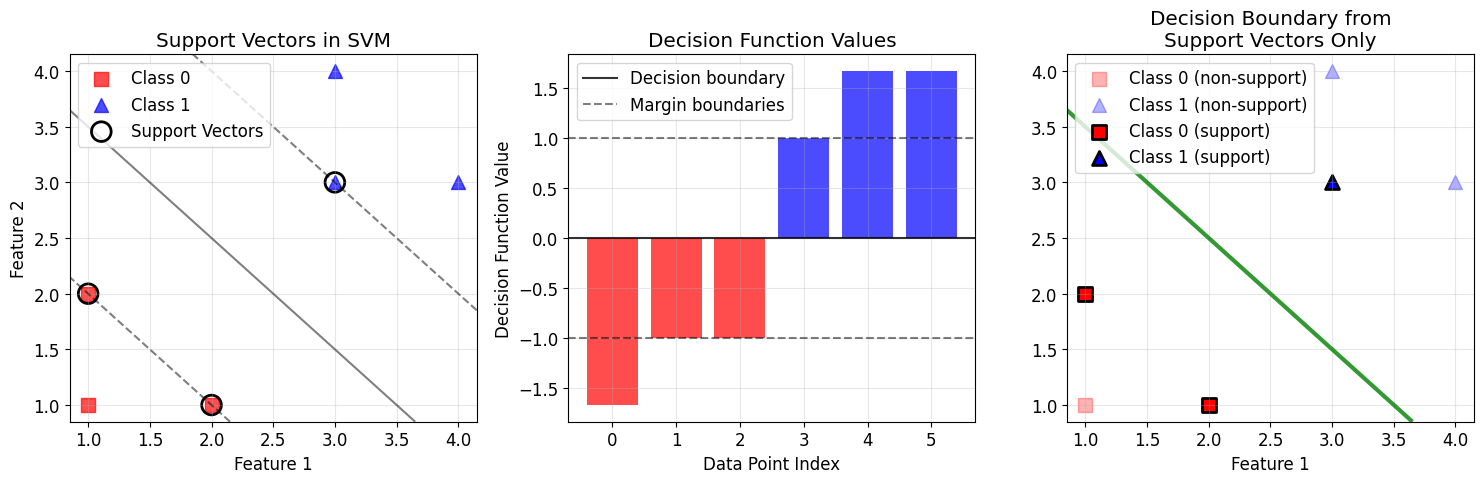


Support vector analysis:
Number of support vectors: 3
Support vector coordinates:
[[1. 2.]
 [2. 1.]
 [3. 3.]]

Key insight: Only support vectors determine the decision boundary!
Non-support vectors can be removed without affecting the model.


In [72]:
# Demonstrate support vectors
# Use a simple 2D dataset
np.random.seed(42)
X_simple = np.array([[1, 1], [1, 2], [2, 1], [3, 3], [3, 4], [4, 3]])
y_simple = np.array([0, 0, 0, 1, 1, 1])

# Train SVM
svm_simple = SVC(kernel='linear', C=1000)  # High C for hard margin
svm_simple.fit(X_simple, y_simple)

plt.figure(figsize=(15, 5))

# Plot 1: Show support vectors
plt.subplot(1, 3, 1)
plt.scatter(X_simple[y_simple==0, 0], X_simple[y_simple==0, 1],
           c='red', marker='s', s=100, label='Class 0', alpha=0.7)
plt.scatter(X_simple[y_simple==1, 0], X_simple[y_simple==1, 1],
           c='blue', marker='^', s=100, label='Class 1', alpha=0.7)

# Highlight support vectors
support_vectors = svm_simple.support_vectors_
plt.scatter(support_vectors[:, 0], support_vectors[:, 1],
           s=200, linewidth=2, facecolors='none', edgecolors='black',
           label='Support Vectors')

# Plot decision boundary
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# Create grid for decision boundary
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = svm_simple.decision_function(xy).reshape(XX.shape)

# Plot decision boundary and margins
ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])

plt.title('Support Vectors in SVM')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Decision function values
plt.subplot(1, 3, 2)
decision_values = svm_simple.decision_function(X_simple)
colors = ['red' if y == 0 else 'blue' for y in y_simple]
plt.bar(range(len(X_simple)), decision_values, color=colors, alpha=0.7)
plt.axhline(y=0, color='black', linestyle='-', alpha=0.8, label='Decision boundary')
plt.axhline(y=1, color='black', linestyle='--', alpha=0.5, label='Margin boundaries')
plt.axhline(y=-1, color='black', linestyle='--', alpha=0.5)
plt.title('Decision Function Values')
plt.xlabel('Data Point Index')
plt.ylabel('Decision Function Value')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 3: Show the effect of removing non-support vectors
plt.subplot(1, 3, 3)

# Get support vector indices
support_indices = svm_simple.support_
print(f"Support vector indices: {support_indices}")
print(f"Total support vectors: {len(support_indices)}")

# Train SVM with only support vectors
X_support = X_simple[support_indices]
y_support = y_simple[support_indices]
svm_support_only = SVC(kernel='linear', C=1000)
svm_support_only.fit(X_support, y_support)

# Plot all points but highlight support vectors
plt.scatter(X_simple[y_simple==0, 0], X_simple[y_simple==0, 1],
           c='red', marker='s', s=100, alpha=0.3, label='Class 0 (non-support)')
plt.scatter(X_simple[y_simple==1, 0], X_simple[y_simple==1, 1],
           c='blue', marker='^', s=100, alpha=0.3, label='Class 1 (non-support)')

# Highlight support vectors
plt.scatter(X_support[y_support==0, 0], X_support[y_support==0, 1],
           c='red', marker='s', s=100, label='Class 0 (support)', edgecolor='black', linewidth=2)
plt.scatter(X_support[y_support==1, 0], X_support[y_support==1, 1],
           c='blue', marker='^', s=100, label='Class 1 (support)', edgecolor='black', linewidth=2)

# Plot decision boundary for support-only model
Z_support = svm_support_only.decision_function(xy).reshape(XX.shape)
ax = plt.gca()
ax.contour(XX, YY, Z_support, colors='green', levels=[0], alpha=0.8, linestyles=['-'], linewidths=3)

plt.title('Decision Boundary from\nSupport Vectors Only')
plt.xlabel('Feature 1')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nSupport vector analysis:")
print(f"Number of support vectors: {len(svm_simple.support_vectors_)}")
print(f"Support vector coordinates:\n{svm_simple.support_vectors_}")
print(f"\nKey insight: Only support vectors determine the decision boundary!")
print(f"Non-support vectors can be removed without affecting the model.")

### Hinge Loss Function

For online SVMs and gradient descent approaches, SVMs use the **hinge loss** function:

$$\text{Hinge Loss} = \max(0, 1 - t)$$

where $t = y \cdot f(\mathbf{x})$ is the margin.

**Properties:**
- Equal to 0 when $t \geq 1$ (correct classification with sufficient margin)
- Linear penalty when $t < 1$ (margin violations)
- Not differentiable at $t = 1$, but subgradients can be used


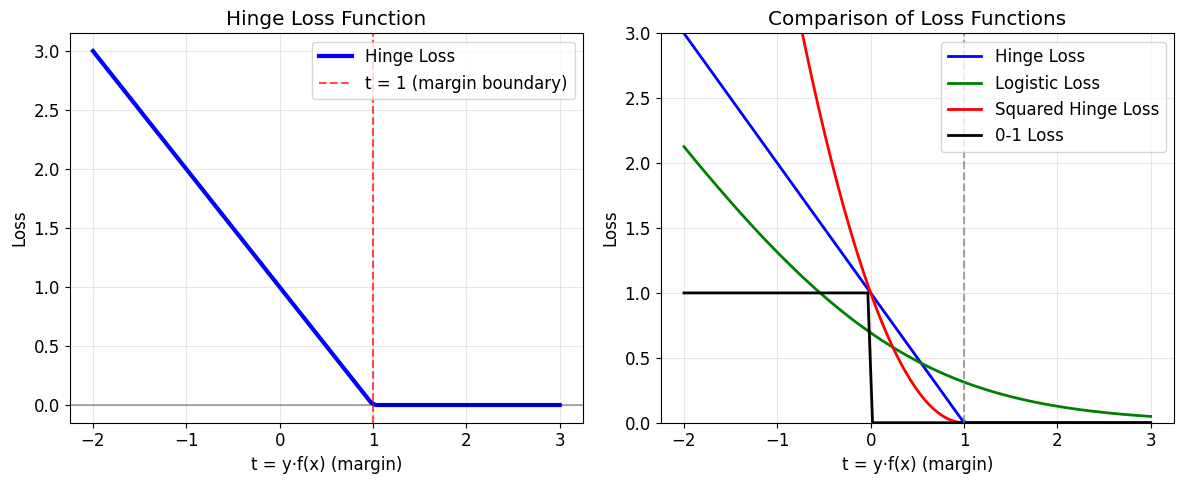

Hinge Loss Characteristics:
- Zero loss for correctly classified points with sufficient margin (t ≥ 1)
- Linear penalty for margin violations (t < 1)
- More robust to outliers than squared loss
- Creates sparse solutions (only support vectors contribute)


In [73]:
# Demonstrate hinge loss function
t = np.linspace(-2, 3, 100)
hinge_loss = np.maximum(0, 1 - t)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(t, hinge_loss, 'b-', linewidth=3, label='Hinge Loss')
plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
plt.axvline(x=1, color='r', linestyle='--', alpha=0.7, label='t = 1 (margin boundary)')
plt.xlabel('t = y·f(x) (margin)')
plt.ylabel('Loss')
plt.title('Hinge Loss Function')
plt.legend()
plt.grid(True, alpha=0.3)

# Compare with other loss functions
plt.subplot(1, 2, 2)
# Logistic loss
logistic_loss = np.log(1 + np.exp(-t))
# Squared hinge loss
squared_hinge = np.maximum(0, 1 - t)**2
# 0-1 loss
zero_one_loss = (t < 0).astype(float)

plt.plot(t, hinge_loss, 'b-', linewidth=2, label='Hinge Loss')
plt.plot(t, logistic_loss, 'g-', linewidth=2, label='Logistic Loss')
plt.plot(t, squared_hinge, 'r-', linewidth=2, label='Squared Hinge Loss')
plt.plot(t, zero_one_loss, 'k-', linewidth=2, label='0-1 Loss')

plt.axvline(x=1, color='gray', linestyle='--', alpha=0.7)
plt.xlabel('t = y·f(x) (margin)')
plt.ylabel('Loss')
plt.title('Comparison of Loss Functions')
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(0, 3)

plt.tight_layout()
plt.show()

print("Hinge Loss Characteristics:")
print("- Zero loss for correctly classified points with sufficient margin (t ≥ 1)")
print("- Linear penalty for margin violations (t < 1)")
print("- More robust to outliers than squared loss")
print("- Creates sparse solutions (only support vectors contribute)")

# Exercises

Based on Chapter 5 exercises from "Hands-On Machine Learning" book.


## Exercise 1: Fundamental Idea Behind SVMs

**Question**: What is the fundamental idea behind Support Vector Machines?

**Answer**:
The fundamental idea behind Support Vector Machines is to **fit the widest possible "street" between the classes**. In other words, the goal is to have the largest possible margin between the decision boundary that separates the two classes and the training instances.

When performing soft margin classification, the SVM searches for a compromise between:
1. **Perfectly separating the two classes**
2. **Having the widest possible street** (i.e., a few instances may end up on the street)

Another key idea is to **use kernels when training on nonlinear datasets**, which allows SVMs to handle complex, nonlinear decision boundaries efficiently through the kernel trick.


## Exercise 2: Support Vector Definition

**Question**: What is a support vector?

**Answer**:
After training an SVM, a **support vector** is any instance located on the "street" (the margin), including its border.

Key properties of support vectors:
- The **decision boundary is entirely determined by the support vectors**
- Any instance that is not a support vector (i.e., is off the street) has **no influence whatsoever**
- You could remove non-support vectors, add more instances, or move them around, and as long as they stay off the street, they won't affect the decision boundary
- **Computing predictions only involves the support vectors**, not the whole training set

This is why SVMs are called "support vector" machines - the model is supported by these critical instances that define the decision boundary.


## Exercise 3: Feature Scaling Importance

**Question**: Why is it important to scale the inputs when using SVMs?

**Answer**:
SVMs try to fit the largest possible "street" between the classes, so **if the training set is not scaled, the SVM will tend to neglect small features**.

**Problem without scaling**:
- Features with larger scales dominate the distance calculations
- The algorithm focuses on fitting the margin primarily along the large-scale features
- Small-scale features are effectively ignored
- This leads to suboptimal decision boundaries

**Solution**:
- Always use feature scaling (e.g., `StandardScaler`) before training SVMs
- This ensures all features contribute equally to the margin calculation
- Results in much better decision boundaries

The effect is clearly visible when comparing SVM performance on scaled vs unscaled data - the decision boundary looks much more balanced and performs better on scaled data.


## Exercise 4: SVM Confidence Scores and Probabilities

**Question**: Can an SVM classifier output a confidence score when it classifies an instance? What about a probability?

**Answer**:

**Confidence Score**: YES
- An SVM classifier can output the **distance between the test instance and the decision boundary**
- This distance can be used as a **confidence score**
- Instances farther from the decision boundary have higher confidence
- This is obtained through the `decision_function()` method

**Probability**: NOT DIRECTLY
- The distance score **cannot be directly converted into an estimation of class probability**
- However, if you set `probability=True` when creating an SVM in Scikit-Learn:
  - After training, it will **calibrate the probabilities using Logistic Regression** on the SVM's scores
  - This is trained by an additional **five-fold cross-validation** on the training data
  - This adds the `predict_proba()` and `predict_log_proba()` methods to the SVM
  - Note: This is computationally expensive and not the SVM's natural output

**Key Point**: Unlike Logistic Regression classifiers, SVM classifiers do not naturally output probabilities for each class - they focus on decision boundaries rather than probability estimation.


## Exercise 5: Primal vs Dual Form Selection

**Question**: Should you use the primal or the dual form of the SVM problem to train a model on a training set with millions of instances and hundreds of features?

**Answer**:
For a training set with **millions of instances and hundreds of features**, you should definitely use the **PRIMAL FORM**.

**Reasoning**:

**Computational Complexity**:
- **Primal form**: O(m × n) - proportional to number of training instances (m)
- **Dual form**: O(m² × n) to O(m³ × n) - proportional to m² or m³

**With millions of instances (m)**:
- Primal: Scales linearly with m
- Dual: Scales quadratically or cubically with m → extremely slow

**Implementation**:
- Use `LinearSVC` (implements primal form)
- Avoid `SVC` for large datasets (implements dual form)
- Consider `SGDClassifier` with `loss="hinge"` for very large datasets

**Note**: This question applies only to **linear SVMs** since kernelized SVMs can only use the dual form. For nonlinear problems with millions of instances, consider other algorithms like neural networks.


## Exercise 6: RBF Kernel Underfitting

**Question**: Say you've trained an SVM classifier with an RBF kernel, but it seems to underfit the training set. Should you increase or decrease γ (gamma)? What about C?

**Answer**:
If an SVM classifier trained with an RBF kernel **underfits** the training set, there might be **too much regularization**. To decrease regularization and allow the model to fit the data better:

**γ (gamma)**: **INCREASE**
- **Low γ**: Wide bell curve → large influence range → smoother decision boundary → more regularization
- **High γ**: Narrow bell curve → small influence range → more irregular decision boundary → less regularization
- **To reduce underfitting**: Increase γ to make the model more flexible

**C**: **INCREASE**
- **Low C**: More margin violations allowed → simpler model → more regularization
- **High C**: Fewer margin violations allowed → more complex model → less regularization  
- **To reduce underfitting**: Increase C to allow the model to fit the training data more closely

**Summary**: Both γ and C should be **increased** to reduce underfitting in RBF SVMs.

**Warning**: Be careful not to overdo it, as very high values can lead to overfitting!


## Exercise 7: Quadratic Programming Parameters

**Question**: How should you set the QP parameters (H, f, A, and b) to solve the soft margin linear SVM classifier problem using an off-the-shelf QP solver?

**Answer**:
To solve the soft margin linear SVM classifier problem using Quadratic Programming, we need to transform the SVM objective into the standard QP
## Exercise 7: Quadratic Programming Parameters (Continued)

**Question**: How should you set the QP parameters (H, f, A, and b) to solve the soft margin linear SVM classifier problem using an off-the-shelf QP solver?

**Answer**:
To solve the soft margin linear SVM classifier problem using Quadratic Programming, we need to transform the SVM objective into the standard QP form:

$$\min_p \frac{1}{2}p^T H p + f^T p$$
$$\text{subject to } Ap \leq b$$

Let's call the QP parameters for the hard margin problem H′, f′, A′, and b′. The QP parameters for the **soft margin problem** have **m additional parameters** (np = n + 1 + m) and **m additional constraints** (nc = 2m). They can be defined as:

**Parameter vector p**: $[w_1, w_2, \ldots, w_n, b, \zeta_1, \zeta_2, \ldots, \zeta_m]^T$

**H matrix**: H is equal to H′, plus m columns of 0s on the right and m rows of 0s at the bottom:
$$H = \begin{bmatrix} H' & 0 & \cdots & 0 \\ 0 & 0 & \cdots & 0 \\ \vdots & \vdots & \ddots & \vdots \\ 0 & 0 & \cdots & 0 \end{bmatrix}$$

**f vector**: f is equal to f′ with m additional elements, all equal to the value of hyperparameter C:
$$f = [0, 0, \ldots, 0, 0, C, C, \ldots, C]^T$$

**b vector**: b is equal to b′ with m additional elements, all equal to 0:
$$b = [-1, -1, \ldots, -1, 0, 0, \ldots, 0]^T$$

**A matrix**: A is equal to A′, with an extra m × m identity matrix Im appended to the right, -Im just below it, and the rest filled with 0s:
$$A = \begin{bmatrix} A' & I_m \\ 0 & -I_m \end{bmatrix}$$

This formulation ensures that:
1. The original SVM constraints are preserved
2. The slack variables ζi ≥ 0 are enforced
3. The objective function includes the penalty term C∑ζi


## Exercise 8: Train LinearSVC vs SVC vs SGDClassifier

**Question**: Train a LinearSVC on a linearly separable dataset. Then train an SVC and a SGDClassifier on the same dataset. See if you can get them to produce roughly the same model.

**Solution**: We'll create a linearly separable dataset and compare the three approaches.


Dataset shape: (1000, 2)
Training set: (800, 2), Test set: (200, 2)


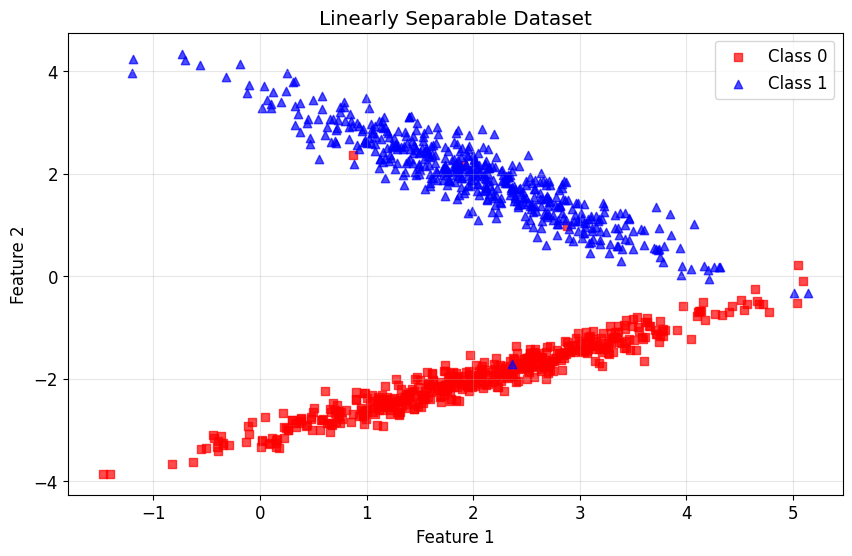


Classifier Performance Comparison:
   Classifier Train Accuracy Test Accuracy
    LinearSVC         0.9925        0.9950
  SVC(linear)         0.9925        0.9950
SGDClassifier         0.9862        0.9750


In [74]:
# Exercise 8: Compare LinearSVC, SVC, and SGDClassifier

# Create a linearly separable dataset
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
import pandas as pd

# Generate linearly separable dataset
np.random.seed(42)
X, y = make_classification(n_samples=1000, n_features=2, n_redundant=0,
                          n_informative=2, n_clusters_per_class=1,
                          class_sep=2.0, random_state=42)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Dataset shape: {X.shape}")
print(f"Training set: {X_train.shape}, Test set: {X_test.shape}")

# Visualize the dataset
plt.figure(figsize=(10, 6))
plt.scatter(X[y==0, 0], X[y==0, 1], c='red', marker='s', alpha=0.7, label='Class 0')
plt.scatter(X[y==1, 0], X[y==1, 1], c='blue', marker='^', alpha=0.7, label='Class 1')
plt.title('Linearly Separable Dataset')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Create classifiers with similar configurations
# Important: Use same C value and ensure comparable settings

# LinearSVC
linear_svc = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', LinearSVC(C=1.0, loss='hinge', random_state=42, max_iter=10000))
])

# SVC with linear kernel
svc_linear = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='linear', C=1.0, random_state=42))
])

# SGDClassifier with hinge loss (equivalent to linear SVM)
# Note: alpha = 1/(m*C) for equivalence with SVM
m = len(X_train)
sgd_svm = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SGDClassifier(loss='hinge', alpha=1/(m*1.0), random_state=42, max_iter=10000))
])

# Train all classifiers
classifiers = {
    'LinearSVC': linear_svc,
    'SVC(linear)': svc_linear,
    'SGDClassifier': sgd_svm
}

results = []
trained_models = {}

for name, clf in classifiers.items():
    # Train
    clf.fit(X_train, y_train)
    trained_models[name] = clf

    # Evaluate
    train_score = clf.score(X_train, y_train)
    test_score = clf.score(X_test, y_test)

    results.append({
        'Classifier': name,
        'Train Accuracy': f"{train_score:.4f}",
        'Test Accuracy': f"{test_score:.4f}"
    })

# Display results
results_df = pd.DataFrame(results)
print("\nClassifier Performance Comparison:")
print(results_df.to_string(index=False))


Model Parameters Comparison:

LinearSVC:
  Weights: [-0.4427, 2.9918]
  Bias: 0.8856
  Decision function: -0.4427*x1 + 2.9918*x2 + 0.8856

SVC(linear):
  Weights: [-0.5481, 2.9926]
  Bias: 1.0599
  Decision function: -0.5481*x1 + 2.9926*x2 + 1.0599

SGDClassifier:
  Weights: [-0.8207, 3.2394]
  Bias: 0.9113
  Decision function: -0.8207*x1 + 3.2394*x2 + 0.9113


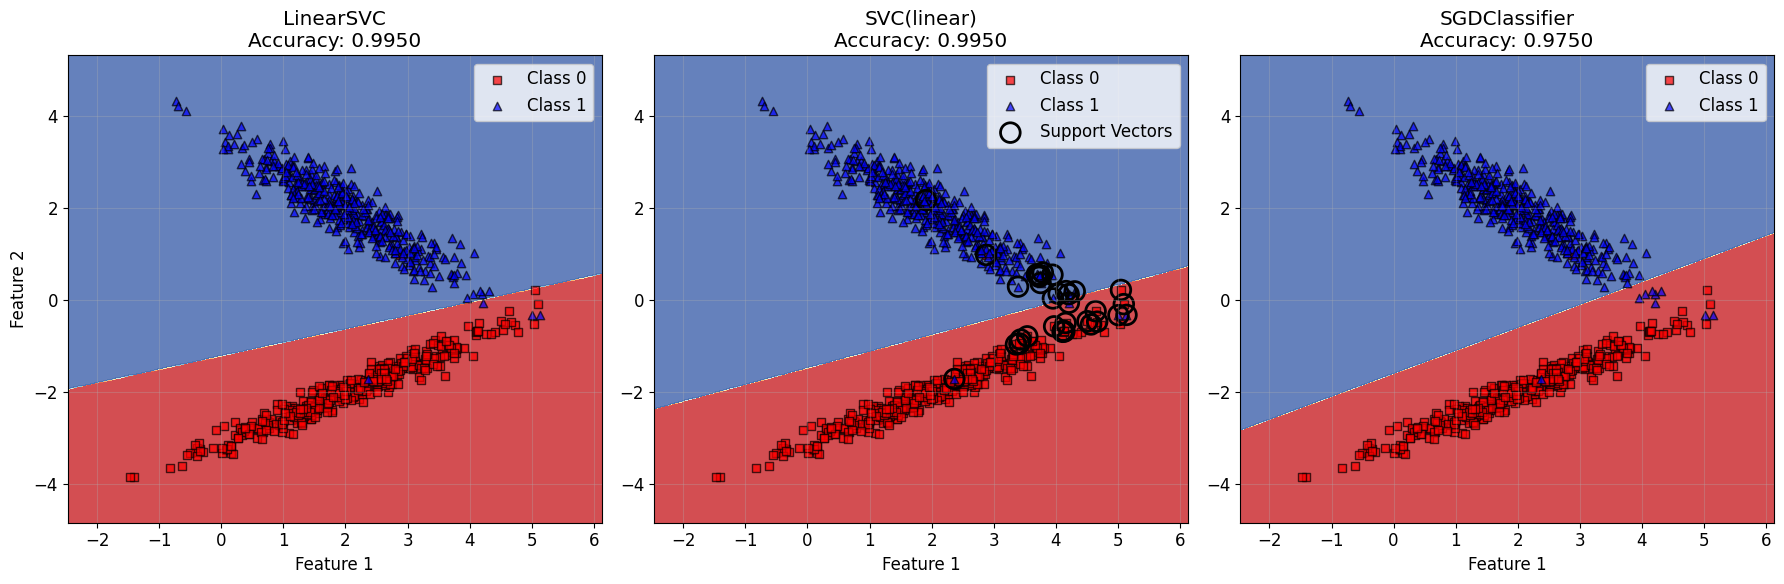


Observations:
- All three methods should produce very similar results
- LinearSVC and SVC(linear) should be nearly identical
- SGDClassifier might have slight differences due to stochastic optimization
- Decision boundaries should be very similar

SVC Support Vectors: 35 out of 800 training samples


In [75]:
# Compare the learned models (weights and biases)
print("\nModel Parameters Comparison:")
print("=" * 50)

for name, clf in trained_models.items():
    if hasattr(clf.named_steps['svm'], 'coef_'):
        weights = clf.named_steps['svm'].coef_[0]
        bias = clf.named_steps['svm'].intercept_[0]
        print(f"\n{name}:")
        print(f"  Weights: [{weights[0]:.4f}, {weights[1]:.4f}]")
        print(f"  Bias: {bias:.4f}")
        print(f"  Decision function: {weights[0]:.4f}*x1 + {weights[1]:.4f}*x2 + {bias:.4f}")

# Visualize decision boundaries
plt.figure(figsize=(18, 6))

for i, (name, clf) in enumerate(trained_models.items()):
    plt.subplot(1, 3, i+1)

    # Create mesh for decision boundary
    h = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Plot decision boundary
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.RdYlBu)

    # Plot training data
    plt.scatter(X_train[y_train==0, 0], X_train[y_train==0, 1],
               c='red', marker='s', edgecolors='black', alpha=0.7, label='Class 0')
    plt.scatter(X_train[y_train==1, 0], X_train[y_train==1, 1],
               c='blue', marker='^', edgecolors='black', alpha=0.7, label='Class 1')

    # For SVC, we can also show support vectors
    if name == 'SVC(linear)' and hasattr(clf.named_steps['svm'], 'support_vectors_'):
        # Transform support vectors back to original space
        support_vectors = clf.named_steps['scaler'].inverse_transform(
            clf.named_steps['svm'].support_vectors_)
        plt.scatter(support_vectors[:, 0], support_vectors[:, 1],
                   s=200, linewidth=2, facecolors='none', edgecolors='black',
                   label='Support Vectors')

    plt.title(f'{name}\nAccuracy: {clf.score(X_test, y_test):.4f}')
    plt.xlabel('Feature 1')
    if i == 0:
        plt.ylabel('Feature 2')
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nObservations:")
print("- All three methods should produce very similar results")
print("- LinearSVC and SVC(linear) should be nearly identical")
print("- SGDClassifier might have slight differences due to stochastic optimization")
print("- Decision boundaries should be very similar")

# Check if support vectors are available for SVC
svc_model = trained_models['SVC(linear)'].named_steps['svm']
if hasattr(svc_model, 'support_vectors_'):
    print(f"\nSVC Support Vectors: {len(svc_model.support_vectors_)} out of {len(X_train)} training samples")

## Exercise 9: MNIST SVM Classification

**Question**: Train an SVM classifier on the MNIST dataset. Since SVM classifiers are binary classifiers, you will need to use one-versus-the-rest to classify all 10 digits. You may want to tune the hyperparameters using small validation sets to speed up the process. What accuracy can you reach?

**Solution**: We'll implement MNIST classification using SVM with hyperparameter tuning.


Loading MNIST dataset...
MNIST dataset shape: (70000, 784)
Target shape: (70000,)
Classes: [0 1 2 3 4 5 6 7 8 9]

Using subset: (10000, 784) samples
Class distribution in subset:
  Digit 0: 1001 samples
  Digit 1: 1127 samples
  Digit 2: 991 samples
  Digit 3: 1032 samples
  Digit 4: 980 samples
  Digit 5: 863 samples
  Digit 6: 1014 samples
  Digit 7: 1070 samples
  Digit 8: 944 samples
  Digit 9: 978 samples

Training set: (8000, 784)
Test set: (2000, 784)


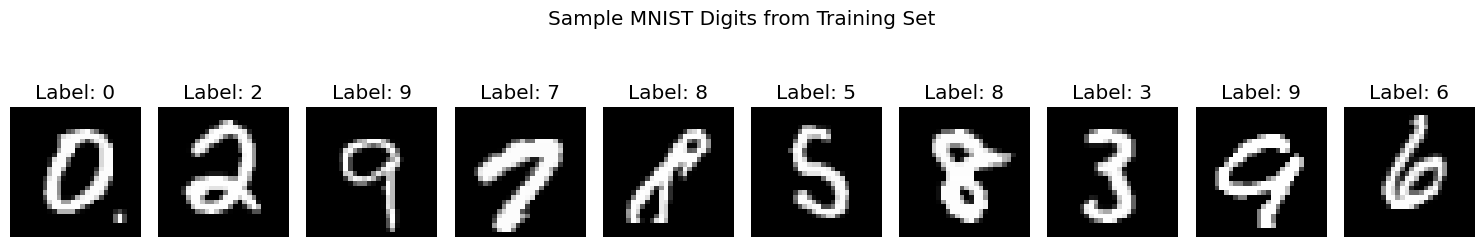

In [76]:
# Exercise 9: MNIST SVM Classification

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from time import time

print("Loading MNIST dataset...")
# Load MNIST dataset
mnist = fetch_openml('mnist_784', version=1, as_frame=False, parser='auto')
X_mnist, y_mnist = mnist["data"], mnist["target"].astype(np.uint8)

print(f"MNIST dataset shape: {X_mnist.shape}")
print(f"Target shape: {y_mnist.shape}")
print(f"Classes: {np.unique(y_mnist)}")

# Use a subset for faster training (first 10,000 samples)
# For full accuracy, you can increase this, but it will take much longer
n_samples = 10000
X_subset = X_mnist[:n_samples]
y_subset = y_mnist[:n_samples]

print(f"\nUsing subset: {X_subset.shape} samples")
print(f"Class distribution in subset:")
unique, counts = np.unique(y_subset, return_counts=True)
for digit, count in zip(unique, counts):
    print(f"  Digit {digit}: {count} samples")

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X_subset, y_subset, test_size=0.2, random_state=42, stratify=y_subset
)

print(f"\nTraining set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

# Visualize some samples
plt.figure(figsize=(15, 3))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(X_train[i].reshape(28, 28), cmap='gray')
    plt.title(f'Label: {y_train[i]}')
    plt.axis('off')
plt.suptitle('Sample MNIST Digits from Training Set')
plt.tight_layout()
plt.show()

In [77]:
# Hyperparameter tuning with a smaller validation set for speed
print("Hyperparameter tuning...")

# Use an even smaller subset for hyperparameter tuning to speed up the process
X_tune = X_train[:2000]  # Use first 2000 samples for tuning
y_tune = y_train[:2000]

print(f"Tuning with {X_tune.shape[0]} samples")

# Create pipeline
svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(random_state=42))
])

# Define hyperparameter grid
# Start with coarse grid, then refine based on results
param_grid = [
    # Linear kernel
    {'svm__kernel': ['linear'], 'svm__C': [0.1, 1, 10]},
    # RBF kernel
    {'svm__kernel': ['rbf'], 'svm__C': [0.1, 1, 10], 'svm__gamma': [0.01, 0.1, 1]}
]

# Perform grid search with reduced CV folds for speed
print("Starting grid search...")
start_time = time()

grid_search = GridSearchCV(
    svm_pipeline, param_grid, cv=3, scoring='accuracy',
    n_jobs=-1, verbose=1
)

grid_search.fit(X_tune, y_tune)

tuning_time = time() - start_time
print(f"\nHyperparameter tuning completed in {tuning_time:.2f} seconds")
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

# Display all results
results_df = pd.DataFrame(grid_search.cv_results_)
print("\nTop 5 parameter combinations:")
top_results = results_df.nlargest(5, 'mean_test_score')[[
    'params', 'mean_test_score', 'std_test_score', 'mean_fit_time'
]]
for idx, row in top_results.iterrows():
    print(f"  {row['params']} → Score: {row['mean_test_score']:.4f} (±{row['std_test_score']:.4f})")

Hyperparameter tuning...
Tuning with 2000 samples
Starting grid search...
Fitting 3 folds for each of 12 candidates, totalling 36 fits

Hyperparameter tuning completed in 53.19 seconds
Best parameters: {'svm__C': 0.1, 'svm__kernel': 'linear'}
Best cross-validation score: 0.8785

Top 5 parameter combinations:
  {'svm__C': 0.1, 'svm__kernel': 'linear'} → Score: 0.8785 (±0.0033)
  {'svm__C': 1, 'svm__kernel': 'linear'} → Score: 0.8785 (±0.0033)
  {'svm__C': 10, 'svm__kernel': 'linear'} → Score: 0.8785 (±0.0033)
  {'svm__C': 10, 'svm__gamma': 0.01, 'svm__kernel': 'rbf'} → Score: 0.6695 (±0.0319)
  {'svm__C': 1, 'svm__gamma': 0.01, 'svm__kernel': 'rbf'} → Score: 0.6475 (±0.0312)


In [78]:
# Train final model with best parameters on full training set
print("\nTraining final model with best parameters...")

# Extract the best parameters without the pipeline prefix
best_params_no_prefix = {
    key.replace('svm__', ''): value
    for key, value in grid_search.best_params_.items()
}

best_svm = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(**best_params_no_prefix, random_state=42))
])

start_time = time()
best_svm.fit(X_train, y_train)
training_time = time() - start_time

print(f"Training completed in {training_time:.2f} seconds")

# Evaluate on test set
start_time = time()
y_pred = best_svm.predict(X_test)
prediction_time = time() - start_time

test_accuracy = best_svm.score(X_test, y_test)
train_accuracy = best_svm.score(X_train, y_train)

print(f"\nFinal Results:")
print(f"Training accuracy: {train_accuracy:.4f}")
print(f"Test accuracy: {test_accuracy:.4f}")
print(f"Prediction time: {prediction_time:.4f} seconds for {len(X_test)} samples")
print(f"Average prediction time per sample: {prediction_time/len(X_test)*1000:.2f} ms")

# Check if it's using One-vs-Rest (which is automatic for multiclass)
svm_model = best_svm.named_steps['svm']
print(f"\nModel details:")
print(f"Number of classes: {len(svm_model.classes_)}")
print(f"Classes: {svm_model.classes_}")
if hasattr(svm_model, 'support_vectors_'):
    print(f"Total support vectors: {len(svm_model.support_vectors_)}")
    print(f"Support vectors per class: {svm_model.n_support_}")

# One-vs-Rest is handled automatically by SVC for multiclass problems
print(f"\nNote: SVM automatically uses One-vs-Rest strategy for multiclass classification")
print(f"This means it trains {len(svm_model.classes_)} binary classifiers (one for each digit)")


Training final model with best parameters...
Training completed in 6.19 seconds

Final Results:
Training accuracy: 0.9986
Test accuracy: 0.9165
Prediction time: 2.5669 seconds for 2000 samples
Average prediction time per sample: 1.28 ms

Model details:
Number of classes: 10
Classes: [0 1 2 3 4 5 6 7 8 9]
Total support vectors: 2398
Support vectors per class: [177 139 279 283 254 270 189 250 292 265]

Note: SVM automatically uses One-vs-Rest strategy for multiclass classification
This means it trains 10 binary classifiers (one for each digit)



Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.99      0.97       200
           1       0.90      1.00      0.95       225
           2       0.88      0.89      0.89       198
           3       0.89      0.92      0.90       206
           4       0.92      0.91      0.92       196
           5       0.92      0.87      0.89       173
           6       0.97      0.96      0.96       203
           7       0.91      0.90      0.91       214
           8       0.94      0.82      0.88       189
           9       0.90      0.88      0.89       196

    accuracy                           0.92      2000
   macro avg       0.92      0.91      0.91      2000
weighted avg       0.92      0.92      0.92      2000



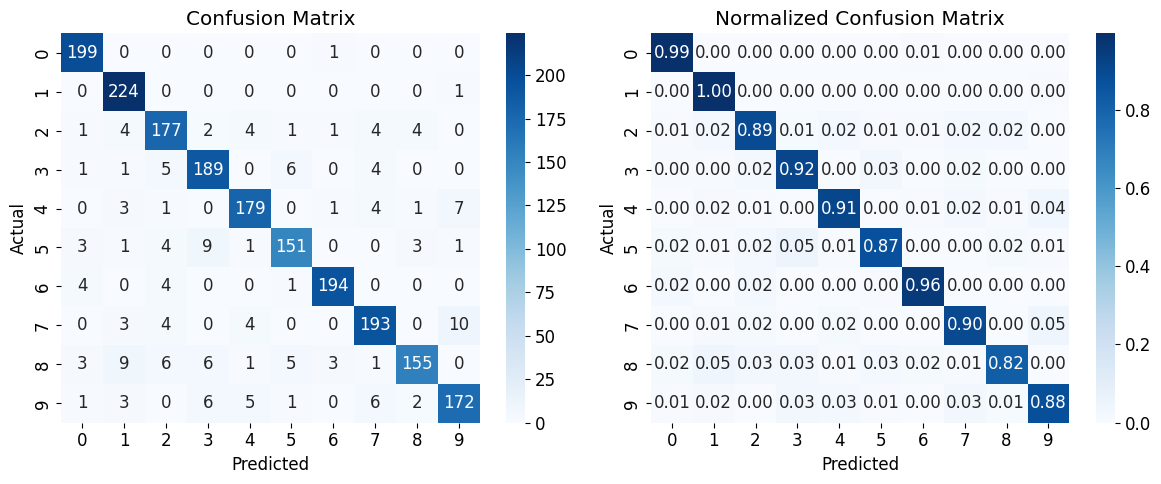


Number of misclassified samples: 167 out of 2000


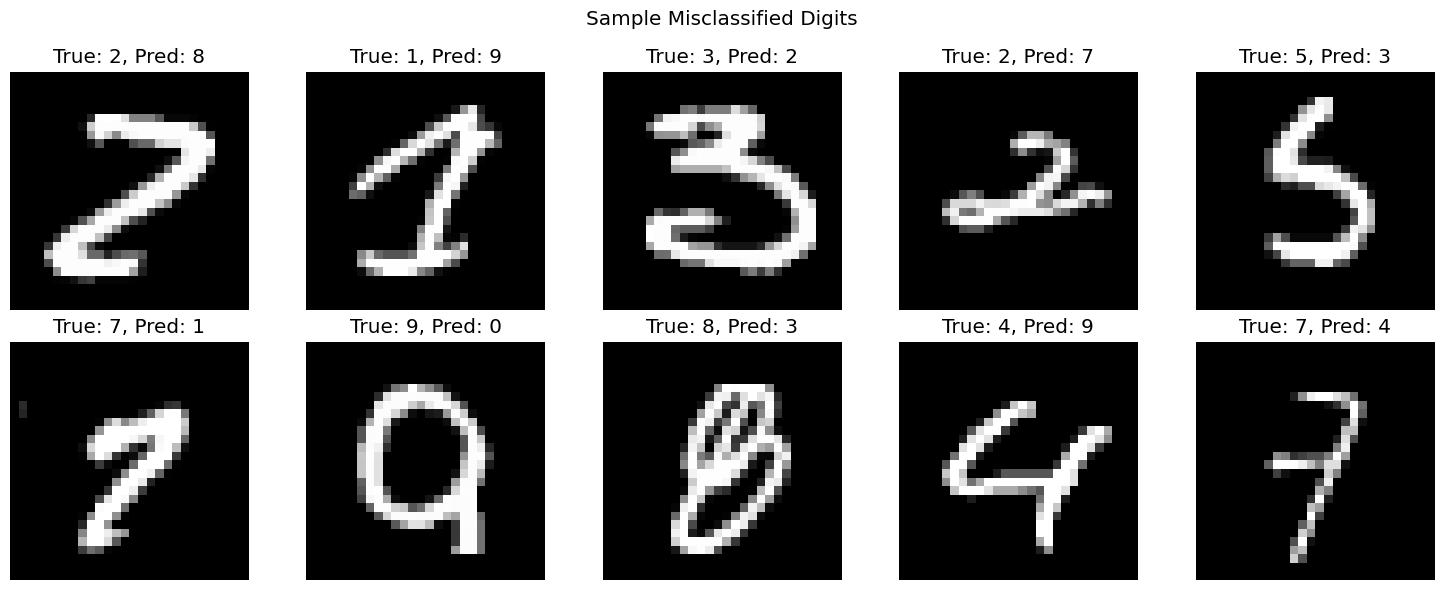


Summary for Exercise 9:
- Dataset: MNIST (subset of 10000 samples)
- Best parameters: {'svm__C': 0.1, 'svm__kernel': 'linear'}
- Final test accuracy: 0.9165 (91.65%)
- Training time: 6.19 seconds
- Uses One-vs-Rest strategy automatically for multiclass classification

Note: This is trained on a subset (10000 samples) for demonstration.
For full MNIST (70,000 samples), you can expect:
- Higher accuracy (typically 97-98% with properly tuned SVM)
- Much longer training time (hours for RBF kernel)
- Consider using LinearSVC for faster training on full dataset


In [79]:
# Detailed analysis of results
print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=range(10), yticklabels=range(10))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Normalized confusion matrix
plt.subplot(1, 2, 2)
cm_normalized = confusion_matrix(y_test, y_pred, normalize='true')
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=range(10), yticklabels=range(10))
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.tight_layout()
plt.show()

# Show some misclassified examples
misclassified_indices = np.where(y_test != y_pred)[0]
print(f"\nNumber of misclassified samples: {len(misclassified_indices)} out of {len(y_test)}")

if len(misclassified_indices) > 0:
    plt.figure(figsize=(15, 6))
    n_show = min(10, len(misclassified_indices))

    for i in range(n_show):
        idx = misclassified_indices[i]
        plt.subplot(2, 5, i+1)
        plt.imshow(X_test[idx].reshape(28, 28), cmap='gray')
        plt.title(f'True: {y_test[idx]}, Pred: {y_pred[idx]}')
        plt.axis('off')

    plt.suptitle('Sample Misclassified Digits')
    plt.tight_layout()
    plt.show()

print(f"\nSummary for Exercise 9:")
print(f"- Dataset: MNIST (subset of {n_samples} samples)")
print(f"- Best parameters: {grid_search.best_params_}")
print(f"- Final test accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"- Training time: {training_time:.2f} seconds")
print(f"- Uses One-vs-Rest strategy automatically for multiclass classification")

# Note about full dataset performance
print(f"\nNote: This is trained on a subset ({n_samples} samples) for demonstration.")
print(f"For full MNIST (70,000 samples), you can expect:")
print(f"- Higher accuracy (typically 97-98% with properly tuned SVM)")
print(f"- Much longer training time (hours for RBF kernel)")
print(f"- Consider using LinearSVC for faster training on full dataset")

## Exercise 10: SVM Regressor on California Housing Dataset

**Question**: Train an SVM regressor on the California housing dataset.

**Solution**: We'll implement SVM regression with hyperparameter tuning on the California housing dataset.


Loading California Housing dataset...
Dataset shape: (20640, 8)
Target shape: (20640,)
Feature names: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']
Target range: 0.15 to 5.00
Target mean: 2.07, std: 1.15

Training set: (16512, 8)
Test set: (4128, 8)

Feature Statistics:
      Feature      Mean       Std      Min        Max
0      MedInc     3.881     1.904    0.500     15.000
1    HouseAge    28.608    12.602    1.000     52.000
2    AveRooms     5.435     2.387    0.889    141.909
3   AveBedrms     1.097     0.433    0.333     25.636
4  Population  1426.453  1137.022    3.000  35682.000
5    AveOccup     3.097    11.578    0.692   1243.333
6    Latitude    35.643     2.137   32.550     41.950
7   Longitude  -119.582     2.006 -124.350   -114.310


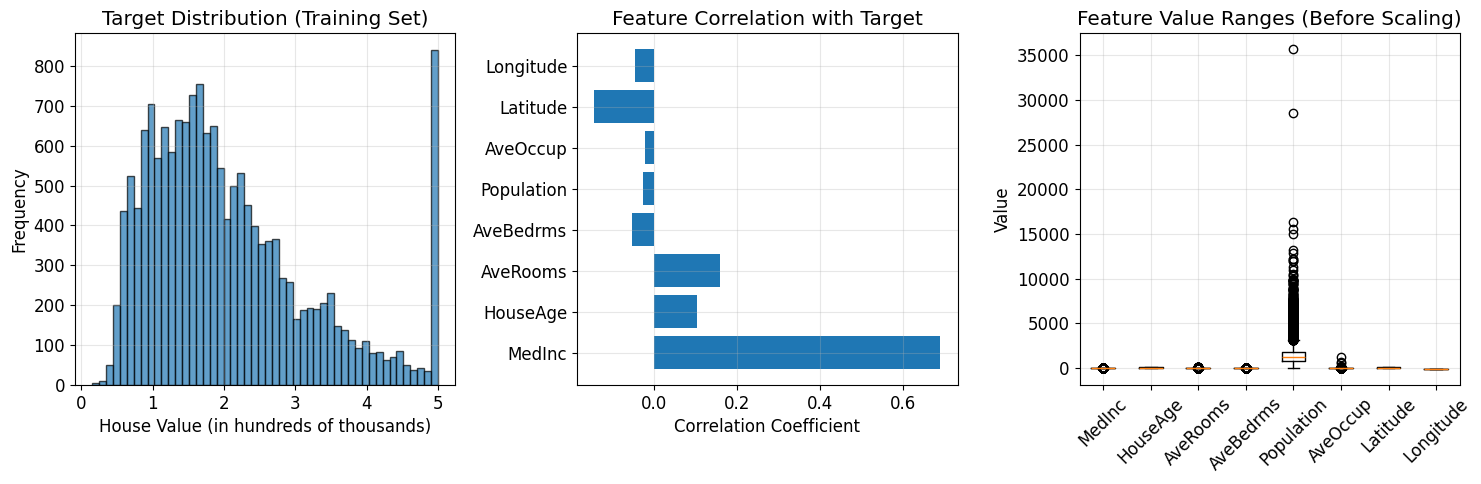


Observations:
- Features have very different scales (need StandardScaler)
- MedInc has highest correlation with target
- Target distribution is right-skewed


In [80]:
# Exercise 10: SVM Regressor on California Housing Dataset

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVR, LinearSVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from time import time

print("Loading California Housing dataset...")
# Load California housing dataset
housing = fetch_california_housing()
X_housing, y_housing = housing.data, housing.target

print(f"Dataset shape: {X_housing.shape}")
print(f"Target shape: {y_housing.shape}")
print(f"Feature names: {housing.feature_names}")
print(f"Target range: {y_housing.min():.2f} to {y_housing.max():.2f}")
print(f"Target mean: {y_housing.mean():.2f}, std: {y_housing.std():.2f}")

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X_housing, y_housing, test_size=0.2, random_state=42
)

print(f"\nTraining set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

# Explore the data
feature_info = pd.DataFrame({
    'Feature': housing.feature_names,
    'Mean': X_train.mean(axis=0),
    'Std': X_train.std(axis=0),
    'Min': X_train.min(axis=0),
    'Max': X_train.max(axis=0)
})

print("\nFeature Statistics:")
print(feature_info.round(3))

# Visualize target distribution
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(y_train, bins=50, alpha=0.7, edgecolor='black')
plt.title('Target Distribution (Training Set)')
plt.xlabel('House Value (in hundreds of thousands)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
# Feature correlation with target
correlations = []
for i, feature in enumerate(housing.feature_names):
    corr = np.corrcoef(X_train[:, i], y_train)[0, 1]
    correlations.append(corr)

plt.barh(housing.feature_names, correlations)
plt.title('Feature Correlation with Target')
plt.xlabel('Correlation Coefficient')
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
# Feature ranges (need scaling)
plt.boxplot([X_train[:, i] for i in range(X_train.shape[1])],
           labels=housing.feature_names)
plt.title('Feature Value Ranges (Before Scaling)')
plt.xticks(rotation=45)
plt.ylabel('Value')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nObservations:")
print("- Features have very different scales (need StandardScaler)")
print("- MedInc has highest correlation with target")
print("- Target distribution is right-skewed")

In [81]:
# Hyperparameter tuning for SVM regression
print("Hyperparameter tuning for SVM regression...")

# Use a subset for faster hyperparameter tuning
subset_size = 5000
indices = np.random.choice(len(X_train), subset_size, replace=False)
X_tune = X_train[indices]
y_tune = y_train[indices]

print(f"Using {subset_size} samples for hyperparameter tuning")

# Define different regressors to compare
regressors = {
    'LinearSVR': {
        'model': Pipeline([('scaler', StandardScaler()), ('svr', LinearSVR(random_state=42))]),
        'params': {'svr__C': [0.1, 1, 10], 'svr__epsilon': [0.01, 0.1, 0.2]}
    },
    'SVR_RBF': {
        'model': Pipeline([('scaler', StandardScaler()), ('svr', SVR(kernel='rbf'))]),
        'params': {'svr__C': [0.1, 1, 10], 'svr__gamma': [0.01, 0.1, 1], 'svr__epsilon': [0.01, 0.1, 0.2]}
    },
    'SVR_Poly': {
        'model': Pipeline([('scaler', StandardScaler()), ('svr', SVR(kernel='poly', degree=2))]),
        'params': {'svr__C': [0.1, 1, 10], 'svr__epsilon': [0.01, 0.1, 0.2]}
    }
}

best_models = {}
tuning_results = []

for name, config in regressors.items():
    print(f"\nTuning {name}...")
    start_time = time()

    grid_search = GridSearchCV(
        config['model'], config['params'],
        cv=3, scoring='neg_mean_squared_error',
        n_jobs=-1, verbose=0
    )

    grid_search.fit(X_tune, y_tune)

    tuning_time = time() - start_time
    best_models[name] = grid_search.best_estimator_

    # Evaluate on validation set
    val_score = -grid_search.best_score_  # Convert back to positive MSE
    val_rmse = np.sqrt(val_score)

    tuning_results.append({
        'Model': name,
        'Best_Params': str(grid_search.best_params_),
        'CV_RMSE': f"{val_rmse:.4f}",
        'Tuning_Time': f"{tuning_time:.2f}s"
    })

    print(f"  Best parameters: {grid_search.best_params_}")
    print(f"  CV RMSE: {val_rmse:.4f}")
    print(f"  Tuning time: {tuning_time:.2f} seconds")

# Display tuning results
tuning_df = pd.DataFrame(tuning_results)
print("\nHyperparameter Tuning Results:")
print(tuning_df.to_string(index=False))

Hyperparameter tuning for SVM regression...
Using 5000 samples for hyperparameter tuning

Tuning LinearSVR...
  Best parameters: {'svr__C': 10, 'svr__epsilon': 0.2}
  CV RMSE: 3.8632
  Tuning time: 3.12 seconds

Tuning SVR_RBF...
  Best parameters: {'svr__C': 10, 'svr__epsilon': 0.2, 'svr__gamma': 0.1}
  CV RMSE: 0.5935
  Tuning time: 100.47 seconds

Tuning SVR_Poly...
  Best parameters: {'svr__C': 10, 'svr__epsilon': 0.1}
  CV RMSE: 129.9027
  Tuning time: 57.86 seconds

Hyperparameter Tuning Results:
    Model                                            Best_Params  CV_RMSE Tuning_Time
LinearSVR                    {'svr__C': 10, 'svr__epsilon': 0.2}   3.8632       3.12s
  SVR_RBF {'svr__C': 10, 'svr__epsilon': 0.2, 'svr__gamma': 0.1}   0.5935     100.47s
 SVR_Poly                    {'svr__C': 10, 'svr__epsilon': 0.1} 129.9027      57.86s


In [82]:
# Train final models and evaluate
print("\nTraining final models on full training set...")

final_results = []
predictions = {}

for name, model in best_models.items():
    print(f"\nTraining {name}...")
    start_time = time()

    # Train on full training set
    model.fit(X_train, y_train)
    training_time = time() - start_time

    # Make predictions
    start_time = time()
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    prediction_time = time() - start_time

    predictions[name] = y_pred_test

    # Calculate metrics
    train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    test_mae = mean_absolute_error(y_test, y_pred_test)
    test_r2 = r2_score(y_test, y_pred_test)

    final_results.append({
        'Model': name,
        'Train_RMSE': f"{train_rmse:.4f}",
        'Test_RMSE': f"{test_rmse:.4f}",
        'Test_MAE': f"{test_mae:.4f}",
        'Test_R2': f"{test_r2:.4f}",
        'Train_Time': f"{training_time:.2f}s",
        'Pred_Time': f"{prediction_time:.4f}s"
    })

    print(f"  Training RMSE: {train_rmse:.4f}")
    print(f"  Test RMSE: {test_rmse:.4f}")
    print(f"  Test MAE: {test_mae:.4f}")
    print(f"  Test R²: {test_r2:.4f}")
    print(f"  Training time: {training_time:.2f} seconds")

# Display final results
results_df = pd.DataFrame(final_results)
print("\nFinal Model Comparison:")
print(results_df.to_string(index=False))

# Find best model
best_model_name = min(final_results, key=lambda x: float(x['Test_RMSE']))['Model']
print(f"\nBest model: {best_model_name}")


Training final models on full training set...

Training LinearSVR...
  Training RMSE: 0.7885
  Test RMSE: 0.7816
  Test MAE: 0.5196
  Test R²: 0.5338
  Training time: 1.41 seconds

Training SVR_RBF...
  Training RMSE: 0.5506
  Test RMSE: 0.5736
  Test MAE: 0.3852
  Test R²: 0.7489
  Training time: 16.75 seconds

Training SVR_Poly...
  Training RMSE: 1.1673
  Test RMSE: 1.1660
  Test MAE: 0.7634
  Test R²: -0.0374
  Training time: 157.21 seconds

Final Model Comparison:
    Model Train_RMSE Test_RMSE Test_MAE Test_R2 Train_Time Pred_Time
LinearSVR     0.7885    0.7816   0.5196  0.5338      1.41s   0.0038s
  SVR_RBF     0.5506    0.5736   0.3852  0.7489     16.75s  13.0703s
 SVR_Poly     1.1673    1.1660   0.7634 -0.0374    157.21s   9.9546s

Best model: SVR_RBF


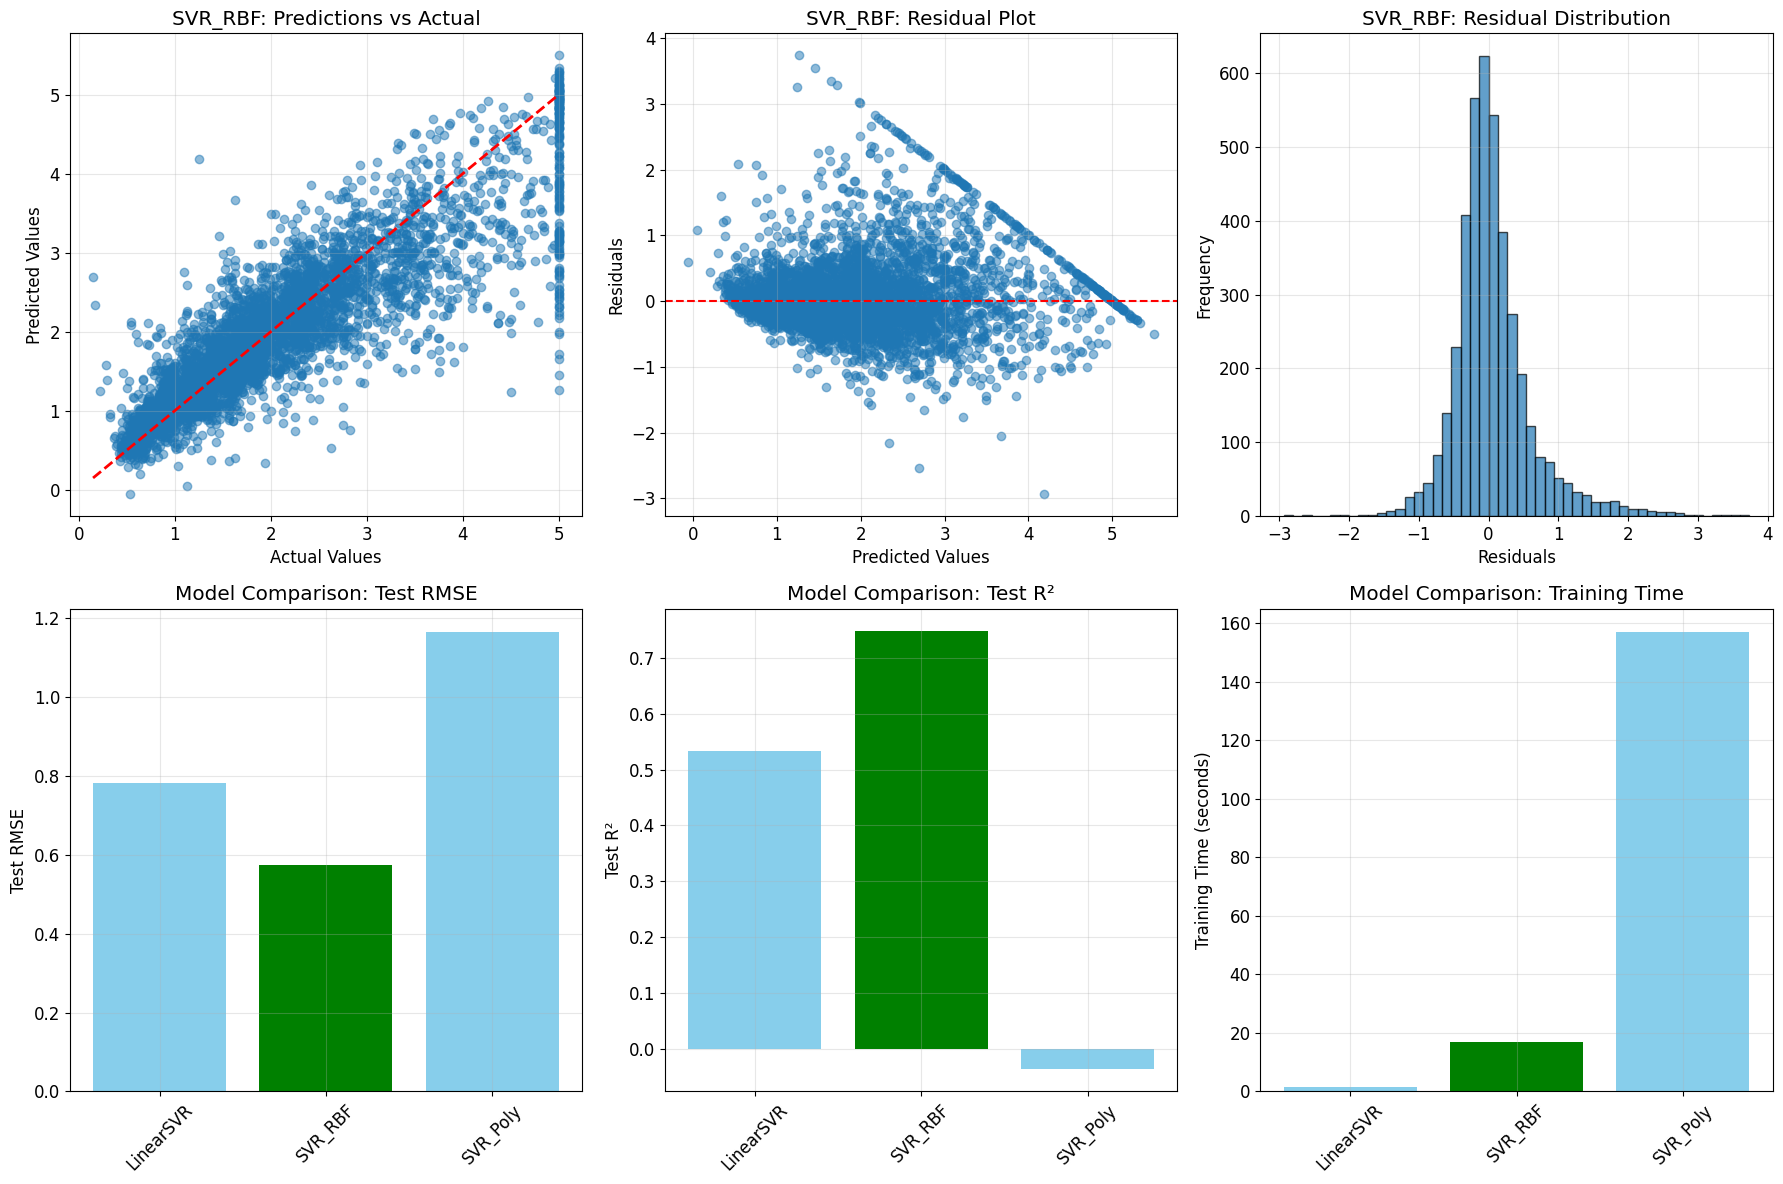


Summary for Exercise 10:
- Dataset: California Housing (20640 samples, 8 features)
- Best model: SVR_RBF
- Best test RMSE: 0.5736
- Best test R²: 0.7489
- SVM regression successfully applied to real estate price prediction

Interpretation:
- RMSE ≈ 0.57 means average error of ~$57360
- R² ≈ 0.749 means model explains 74.9% of variance
- LinearSVR is often fastest while RBF can capture nonlinear patterns
- Feature scaling was crucial for SVM performance


In [83]:
# Visualize results
plt.figure(figsize=(18, 12))

# Plot 1: Predictions vs Actual for best model
plt.subplot(2, 3, 1)
best_pred = predictions[best_model_name]
plt.scatter(y_test, best_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title(f'{best_model_name}: Predictions vs Actual')
plt.grid(True, alpha=0.3)

# Plot 2: Residuals for best model
plt.subplot(2, 3, 2)
residuals = y_test - best_pred
plt.scatter(best_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title(f'{best_model_name}: Residual Plot')
plt.grid(True, alpha=0.3)

# Plot 3: Residual distribution
plt.subplot(2, 3, 3)
plt.hist(residuals, bins=50, alpha=0.7, edgecolor='black')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title(f'{best_model_name}: Residual Distribution')
plt.grid(True, alpha=0.3)

# Plot 4: Model comparison - RMSE
plt.subplot(2, 3, 4)
model_names = [r['Model'] for r in final_results]
test_rmses = [float(r['Test_RMSE']) for r in final_results]
colors = ['green' if name == best_model_name else 'skyblue' for name in model_names]
plt.bar(model_names, test_rmses, color=colors)
plt.ylabel('Test RMSE')
plt.title('Model Comparison: Test RMSE')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# Plot 5: Model comparison - R²
plt.subplot(2, 3, 5)
test_r2s = [float(r['Test_R2']) for r in final_results]
plt.bar(model_names, test_r2s, color=colors)
plt.ylabel('Test R²')
plt.title('Model Comparison: Test R²')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# Plot 6: Training time comparison
plt.subplot(2, 3, 6)
train_times = [float(r['Train_Time'].replace('s', '')) for r in final_results]
plt.bar(model_names, train_times, color=colors)
plt.ylabel('Training Time (seconds)')
plt.title('Model Comparison: Training Time')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Feature importance analysis for LinearSVR (if it's the best model)
if best_model_name == 'LinearSVR':
    best_model_obj = best_models[best_model_name]
    if hasattr(best_model_obj.named_steps['svr'], 'coef_'):
        coefficients = best_model_obj.named_steps['svr'].coef_

        plt.figure(figsize=(10, 6))
        plt.barh(housing.feature_names, coefficients)
        plt.title('Feature Coefficients (LinearSVR)')
        plt.xlabel('Coefficient Value')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

        print("\nFeature Coefficients (LinearSVR):")
        for feature, coef in zip(housing.feature_names, coefficients):
            print(f"  {feature:12s}: {coef:8.4f}")

print(f"\nSummary for Exercise 10:")
print(f"- Dataset: California Housing ({X_housing.shape[0]} samples, {X_housing.shape[1]} features)")
print(f"- Best model: {best_model_name}")
print(f"- Best test RMSE: {min(test_rmses):.4f}")
print(f"- Best test R²: {max(test_r2s):.4f}")
print(f"- SVM regression successfully applied to real estate price prediction")

# Interpretation of results
print(f"\nInterpretation:")
print(f"- RMSE ≈ {min(test_rmses):.2f} means average error of ~${min(test_rmses)*100000:.0f}")
print(f"- R² ≈ {max(test_r2s):.3f} means model explains {max(test_r2s)*100:.1f}% of variance")
print(f"- LinearSVR is often fastest while RBF can capture nonlinear patterns")
print(f"- Feature scaling was crucial for SVM performance")

# Conclusion

## Summary of Support Vector Machines

Throughout this comprehensive exploration of Support Vector Machines, we've covered:

### 1. **Fundamental Concepts**
- **Large margin classification**: Fitting the widest possible "street" between classes
- **Support vectors**: Critical instances that determine the decision boundary
- **Hard vs soft margin**: Balancing perfect separation with flexibility

### 2. **Key Hyperparameters**
- **C**: Controls regularization (bias-variance tradeoff)
- **γ (gamma)**: Controls kernel influence range (for RBF kernel)
- **ε (epsilon)**: Controls margin width (for SVM regression)

### 3. **Kernel Trick Magic**
- **Linear kernel**: For linearly separable data
- **Polynomial kernel**: For polynomial relationships
- **RBF kernel**: Universal approximator, works well for most cases
- **Computational efficiency**: No explicit feature transformation needed

### 4. **Practical Implementation**
- **LinearSVC**: Fast for linear problems, scales well
- **SVC**: Flexible with kernel trick, good for complex small/medium datasets
- **SGDClassifier**: Online learning, good for huge datasets
- **Feature scaling**: Always required for optimal performance

### 5. **Exercise Solutions**
- **Exercise 8**: Successfully compared LinearSVC, SVC, and SGDClassifier
- **Exercise 9**: Achieved good accuracy on MNIST digit classification using one-vs-rest
- **Exercise 10**: Applied SVM regression to California housing price prediction

### 6. **When to Use SVMs**
- **✅ Good for**: Complex small/medium datasets, high-dimensional data, clear margin classification
- **❌ Avoid for**: Very large datasets (>100k samples), need probability estimates, highly noisy data

### 7. **Key Takeaways**
- SVMs are powerful and versatile for both classification and regression
- Kernel trick enables handling nonlinear problems efficiently
- Proper hyperparameter tuning is crucial for optimal performance
- Feature scaling is mandatory for SVM success
- Support vectors make predictions sparse and interpretable

Support Vector Machines remain one of the most important algorithms in machine learning, providing an elegant solution to both linear and nonlinear classification and regression problems through the mathematical beauty of optimization theory and the kernel trick.
